***

# Diagnosis of pneumonia with convolutional neural networks

***

### Capstone project for Data Science Intensive course, General Assembly
#### Chris McKenzie

***


 <tr>
    <td> <img src="title_image_resize.jpeg" alt="Drawing" style="width: 300px;"/> </td>
    <td> <img src="pneumonia_resize.jpeg" alt="Drawing" style="width: 300px;"/> </td>
    <td> <img src="virus_resize.jpeg" alt="Drawing" style="width: 300px;"/> </td>
    </tr>


--------------------------------------------

### Index
#### [1. Executive summary](#1)
* [1.1 Problem statement](#1.1)
* [1.2 Project aim](#1.2)
* [1.3 Success metrics](#1.3)
* [1.4 Findings](#1.4)
* [1.5 Risks and limitations](#1.5)
* [1.6 Future work](#1.6)

#### [2. Set-up](#2)
* [2.1 Imported libraries](#2.1)
* [2.2 Functions used](#2.2)

#### [3. Data formatting and cleaning](#3)
* [3.1 Importing and pre-processing images](#3.1)
* [3.2 Generating keras input data](#3.2)

#### [4. Classification using a simple CNN](#4)

#### [5. Training deep CNNs from scratch](#5)
* [5.1 ResNet50](#5.1)
* [5.2 InceptionV3](#5.2)

#### [6. Modelling with augmentation](#6)
* [6.1 Generating augmented image sets](#6.1)
* [6.2 ResNet50 modelling using augmented images](#6.2)

#### [7. Transfer learning](#7)
* [7.1 ResNet50](#7.1)
* [7.2 InceptionV3](#7.2)

#### [8. Transfer learning with augmentation](#8)
* [8.1 ResNet50](#8.1)
* [8.2 InceptionV3](#8.2)

#### [9. Conclusions](#9)

#### [10. References](#10)

--------------------------------
## <a id='1'>1. Executive summary</a>

### <a id='1.1'>1.1 Problem statement</a>

Pneumonia is an inflammatory disease of the lungs caused by bacterial, viral or fungal infection. It is one of the leading causes of death worldwide, accounting for approximately 7% of deaths annually. The highest mortality rates are found among young children and the elderly (1). Pneumonia is also a considerably greater burden in the developing world.

Chest radiographs, particularly X-rays, are an important tool for diagnosis and monitoring of pneumonia. However, X-ray imaging requires expert interpretation by a radiologist, which may be a time-limiting step for diagnosis and treatment of patients. Even more pressing is the fact that there is often a shortage of qualified experts in many regions most affected by pneumonia. 


### <a id='1.2'>1.2 Project aim</a>

The aim of this project is to deploy convolutional neural networks (CNNs) to process and classify a collection chest X-ray images to determine whether or not they represent a patient with pneumonia. A collection of approximately 6000 paediatric chest X-ray images were obtained from kaggle.com for this project.


### <a id='1.3'>1.3 Success metrics</a>

This is a supervised classification problem, with the aim of sorting images with known classes into two groups: pneumonia and non-pneumonia. My key metrics for evaluating the performance of difference CNN models will include:

* Accuracy score : The total % of predicted labels that agree with the actual labels

* F1-score: Combined metric of precision and recall, which are the proportion of true positives amongst all predicted positives and the proportion of true positives amongs all expected positives respectively.

* Receiver operating characteristic-Area under curve (AUC-ROC): A curve of the true-positive rate vs. the false-positive rate. This is preferred to accuracy as it takes baseline into account and shows how well the classifier works at different decision thresholds. The closer the area under the curve (AUC) is to 1.0 the more succesful my classifier.


### <a id='1.4'>1.4 Findings</a>

Several CNN architectures were utilised in this project. A basic CNN consisting of 7 layers was attempted first and did not perform above baseline accuracy. Two pre-existing CNN architectures were then tested, ResNet50 and InceptionV3. Both ResNet50 and InceptionV3 achieved an accuracy and F1 score of approximately 0.8 when trained from scratch on un-modified images. Initially, this dropped to roughly 0.7 accuracy and 0.65 F1 score when feature weights trained on ImageNet images were used to extract features before classfication. The best success was achieved when using a pre-trained InceptionV3 network with classifiers trained on an augmented imageset (augmented by random horizontal and vertical translations and horizontal reflections). This model achieved an accuracy and F1 score of 0.87 and an AUC of 0.93. AUC is frequently used as a metric for commercial software in this space, and this AUC score of 0.93 is competitive. In general, CNNs were highly successful at identifying pneumonia X-rays but mis-classified images more often from the non-pneumonia set. While fewer false positives would be desirable, from a diagnostic point of view it is peferable to yield false positives over false negatives.


### <a id='1.5'>1.5 Risks and limitations</a>

* The dataset was imbalanced, with fewer normal chest X-rays than pneumonia X-rays available. This was countered by undersampling the pneumonia set which may have introduced some bias into the models.

* Even the best performing models still carried a risk of mis-classification, in a medical setting these models would likely need to be used in conjunction with other diagnostic or monitoring techniques and expert consultation.

* All chest X-rays were sampled from children aged 1-5 at one particular hospital in Guangzhou, China. There may be limitations to how well the model generalises to X-rays obtained from patients in other age groups.


### <a id='1.6'>1.6 Future work</a>

* Additional fine-tuning of classification layers and trying different augmentation techniques could potentially improve metrics further

* Metrics could also potentially be further improved by implementing an ensemble model consisting of multiple neural networks

* Augmentation of the full dataset may allow the non-pneumonia images to be over-sampled, providing an alternative way to address the class imbalance

* Classifications exist in the dataset for bacterial and viral pneumonia, allowing the problem to be transformed into a three-class classification problem which would address class imbalance and potentially provide medically valuable insight.

-----------------------------

## <a id='2'>2. Set-up</a>

### <a id='2.1'>2.1 Imported libraries</a>

In [137]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
import pydot
%matplotlib inline

from skimage import io
from skimage.transform import rescale, resize
from skimage.color import rgb2gray, gray2rgb

from sklearn.preprocessing import normalize, StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_curve, roc_auc_score, auc

import tensorflow as tf
from tensorflow import keras

### <a id='2.2'>2.2 Functions used</a>

In [2]:
#Define a function to convert grayscale to RGB and resize all images from a folder

def img_process(folder, size):
    """Accepts an folder path as input and returns a list of all images in that folder 
    in grayscale, resized to square x by x dimensions with normalized pixel values"""
    imageset = io.imread_collection(folder)
    normed_images = []
    for i in range(0,len(imageset)):
        try:
            rgb = gray2rgb(imageset[i])
        except:
            rgb = imageset[i]
        resized = resize(rgb, (size,size))
        normed_images.append(resized)
    return normed_images

In [3]:
#Function to generate category labels for each image set

def generate_labels(set1, set2):
    """Takes image sets in different categories and returns a list of binary labels"""
    labels = []
    for i in range(len(set1)):
        labels.append(0)
    for j in range(len(set2)):
        labels.append(1)
    return labels

In [4]:
#Function for decoding class labels from model predictions

def label_decoder(x):
    """Accepts list of model-predicted probabilities and returns binary class label"""
    if x[0] > x[1]:
        label = 0
    else:
        label = 1
    return label

In [5]:
#Class for keras progress logging

class AccuracyHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.acc = []

    def on_epoch_end(self, batch, logs={}):
        self.acc.append(logs.get('acc'))

history = AccuracyHistory()

In [231]:
#Function for plotting accuracy from model text output

def plot_accuracy(log, fig_title):
    with open(log, 'r') as myfile:
        data=myfile.read()
    accs_re = '(?<=val_acc:\s)(\d\.\d+)'
    trainaccs_re = '(?<=\sacc:\s)(\d\.\d+)'
    accs = np.array(re.findall(accs_re,data)).astype(np.float)
    trainaccs = np.array(re.findall(trainaccs_re,data)).astype(np.float)
    epochs = np.arange(1,len(accs)+1)
    ax = plt.gca()
    ax.plot(epochs, accs, 'r', label='Test')
    ax.plot(epochs, trainaccs, 'b', label = 'Train')
    ax.axhline(y=0.625,color='k',linestyle='dashed',alpha=0.5,label='Baseline')
    ax.legend(loc='lower right')
    ax.set_ylim([0,1.1])
    plt.title(fig_title)
    plt.xlabel('Epochs')
    plt.ylabel('Test accuracy')

## <a id='3'>3. Data formatting and cleaning</a>

### <a id='3.1'>3.1 Importing and pre-processing images</a>

Images will first be imported into python using the sk-image library, then read into sk-image collection objects folder-by-folder. As most of the CNNs I'll be using expect a 3-channel (RGB) image, I will also process the images to be in RGB format and also resize to 224 x 224 since this is the default input dimensions for ResNet50. I'll additionally use sklearn's StandardScaler function to create image arrays where pixel values have been standardized.

C:\Users\Chris\Anaconda3\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
C:\Users\Chris\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:1400: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


C:\Users\Chris\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:1400: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)
C:\Users\Chris\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:1400: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


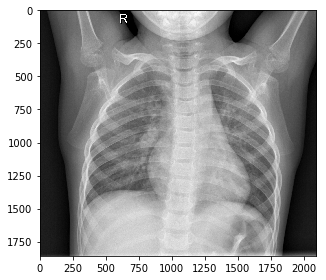

In [77]:
#Example of importing and displaying an image using sk-image
imagepath = '../Capstone_files/train/NORMAL/IM-0115-0001.jpeg'
io.imshow(imagepath)

In [6]:
#Import standard scalers to standardize images
ss = StandardScaler()
ssu = StandardScaler()

In [7]:
#Process the normal training set
folder = '../Capstone_files/train/NORMAL/*.jpeg'
training_n = img_process(folder, 224)

C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\trans

C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\trans

C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\trans

C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\trans

C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\trans

C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\trans

C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\trans

C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\trans

C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\trans

C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\trans

C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\trans

C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\trans

C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\trans

C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\trans

C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\trans

C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\trans

C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\trans

C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\trans

C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\trans

C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\trans

C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\trans

C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\trans

C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\trans

C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\trans

C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\trans

C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\trans

C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\trans

C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\trans

C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\trans

C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\trans

C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\trans

C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\trans

C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\trans

C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\trans

C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\trans

C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\trans

C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\trans

C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\trans

C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\trans

In [8]:
#Process the pneumonia training set
folder = '../Capstone_files/train/PNEUMONIA/*.jpeg'
training_p = img_process(folder, 224)

C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\trans

C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\trans

C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\trans

C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\trans

C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\trans

C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\trans

C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\trans

C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\trans

C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\trans

C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\trans

C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\trans

C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\trans

C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\trans

C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\trans

C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\trans

C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\trans

C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\trans

C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\trans

C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\trans

C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\trans

C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\trans

C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\trans

C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\trans

C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\trans

C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\trans

C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\trans

C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\trans

C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\trans

C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\trans

C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\trans

C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\trans

C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\trans

C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\trans

C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\trans

C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\trans

C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\trans

C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\trans

C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\trans

C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\trans

C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\trans

C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\trans

C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\trans

C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\trans

C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\trans

C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\trans

C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\trans

C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\trans

C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\trans

C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\trans

C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\trans

C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\trans

C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\trans

C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\trans

C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\trans

C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\trans

C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\trans

C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\trans

C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\trans

C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\trans

C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\trans

C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\trans

C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\trans

C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\trans

C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\trans

C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\trans

C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\trans

C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\trans

C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\trans

C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\trans

C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\trans

C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\trans

C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\trans

C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\trans

C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\trans

C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\trans

C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\trans

C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\trans

C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\trans

C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\trans

C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\trans

C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\trans

C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\trans

C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\trans

C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\trans

C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\trans

C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\trans

C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\trans

C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\trans

C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\trans

C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\trans

C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\trans

C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\trans

C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\trans

C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\trans

C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\trans

C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\trans

C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\trans

C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\trans

C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\trans

C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\trans

C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\trans

C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\trans

C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\trans

C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\trans

C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\trans

C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\trans

C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\trans

C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\trans

C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\trans

As there is a significant class imbalance between pneumonia and non-pneumonia images I also generated an undersampled imageset consisting of an equal number of normal and pneumonia images.

In [9]:
#Concatenate the images into one set, confirm size of subsets and calculate baseline accuracy for this set
train_images = training_n + training_p

#Standardise images
train_images_s = [[ss.fit_transform(i) for i in j] for j in train_images]

#Generate category labels
train_labels = generate_labels(training_n, training_p)

#Also create sets with undersampling on the pneumonia set to address imbalance
train_images_usample = training_n + training_p[:1341]
train_images_usample_s = [[ssu.fit_transform(i) for i in j] for j in train_images_usample]
train_labels_usample = generate_labels(training_n, training_p[:1341])

#Check size of each set and work out baseline accuracy
print(len(training_n))
print(len(training_p))
print(len(training_p[:1341]))
print(len(train_images))
baseline_train = (len(training_p)/len(train_images))
print('training baseline: ' + str(baseline_train))

1341
3875
1341
5216
training baseline: 0.7429064417177914


In [10]:
#Repeat the process for the test images
folder = '../Capstone_files/test/NORMAL/*.jpeg'
test_n = img_process(folder, 224)

C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\trans

C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\trans

C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\trans

C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\trans

C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\trans

C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\trans

C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\trans

In [11]:
folder = '../Capstone_files/test/PNEUMONIA/*.jpeg'
test_p = img_process(folder, 224)

C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\trans

C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\trans

C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\trans

C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\trans

C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\trans

C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\trans

C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\trans

C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\trans

C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\trans

C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\trans

C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\trans

In [12]:
test_images = test_n + test_p
#Note the test images are standardised using the mean and std from the undersampled training set, because this is what I'll
#be using below
test_images_s = [[ssu.transform(i) for i in j] for j in test_images]

test_labels = generate_labels(test_n, test_p)

print(len(test_n))
print(len(test_p))
print(len(test_images))
baseline_test = (len(test_p)/len(test_images))
print('test baseline: ' + str(baseline_test))

234
390
624
test baseline: 0.625


In [13]:
#And finally the validation set
folder = '../Capstone_files/val/NORMAL/*.jpeg'
val_n = img_process(folder, 224)

C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\trans

In [14]:
folder = '../Capstone_files/val/PNEUMONIA/*.jpeg'
val_p = img_process(folder, 224)

C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Chris\Anaconda3\lib\site-packages\skimage\trans

In [15]:
val_images = val_n + val_p
val_images_s = [[ssu.transform(i) for i in j] for j in val_images]

val_labels = generate_labels(val_n, val_p)

print(len(val_n))
print(len(val_p))
print(len(val_images))
baseline_val = (len(val_p)/len(val_images))
print('validation baseline: ' + str(baseline_val))

8
8
16
validation baseline: 0.5


### <a id='3.2'>3.2 Generating keras input data</a>

CNNs in keras typically expect 4-dimensional arrays as input, so here I transformed each set of images into a numpy array and then reshaped to ensure the correct dimensions.

In [16]:
#Generate undersampled arrays, standardised and non-standardised
X_train_array = np.array(train_images_usample).reshape(-1, 224, 224, 3)
X_train_array_s = np.array(train_images_usample_s).reshape(-1, 224, 224, 3)
y_train_array = np.array(train_labels_usample).reshape(-1,)

In [17]:
#Generate hot-encoded labels
y_train_array_k = keras.utils.to_categorical(y_train_array)

In [18]:
#Do the same for test images
X_test = np.array(test_images).reshape(-1, 224, 224, 3)
X_test_s = np.array(test_images_s).reshape(-1, 224, 224, 3)
y_test = np.array(test_labels).reshape(-1,)
y_test_k = keras.utils.to_categorical(y_test)

In [19]:
#And the validation set
X_val = np.array(val_images).reshape(-1, 224, 224, 3)
X_val_s = np.array(val_images_s).reshape(-1, 224, 224, 3)
y_val = np.array(val_labels).reshape(-1)
y_val_k = keras.utils.to_categorical(y_val)

## <a id='4'>4. Classification using a simple CNN</a>

To test that the format of my data is correct, I did a trial run using my undersampled data and a very simple 7-layer convolutional net. The initial hyperparameters defined below are used repeatedly throughout this notebook.

In [20]:
#Define some hyperparameters
input_shape = (224, 224, 3)
num_classes = 2
batch_size = 16
epochs = 100

In [248]:
#Define model
model = keras.Sequential()
model.add(keras.layers.Conv2D(32, kernel_size=(5, 5), strides=(1, 1),
                 activation='relu',
                 input_shape=input_shape, data_format='channels_last'))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(keras.layers.Conv2D(64, (5, 5), activation='relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(1000, activation='relu'))
model.add(keras.layers.Dense(num_classes, activation='softmax'))

In [249]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_94 (Conv2D)           (None, 220, 220, 32)      2432      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 110, 110, 32)      0         
_________________________________________________________________
conv2d_95 (Conv2D)           (None, 106, 106, 64)      51264     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 53, 53, 64)        0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 179776)            0         
_________________________________________________________________
dense_8 (Dense)              (None, 1000)              179777000 
_________________________________________________________________
dense_9 (Dense)              (None, 2)                 2002      
Total para

In [21]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

In [28]:
#Fit model
model.fit(X_train_array, y_train_array_k,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_test, y_test_k),
          callbacks=[history])

Train on 2682 samples, validate on 624 samples
Epoch 1/100
2682/2682 [==============================] - 33s 12ms/step - loss: 8.0590 - acc: 0.5000 - val_loss: 6.0443 - val_acc: 0.6250
Epoch 2/100
2682/2682 [==============================] - 32s 12ms/step - loss: 8.0590 - acc: 0.5000 - val_loss: 6.0443 - val_acc: 0.6250
Epoch 3/100
2682/2682 [==============================] - 32s 12ms/step - loss: 8.0590 - acc: 0.5000 - val_loss: 6.0443 - val_acc: 0.6250
Epoch 4/100
2682/2682 [==============================] - 32s 12ms/step - loss: 8.0590 - acc: 0.5000 - val_loss: 6.0443 - val_acc: 0.6250
Epoch 5/100
2682/2682 [==============================] - 32s 12ms/step - loss: 8.0590 - acc: 0.5000 - val_loss: 6.0443 - val_acc: 0.6250
Epoch 6/100
2682/2682 [==============================] - 32s 12ms/step - loss: 8.0590 - acc: 0.5000 - val_loss: 6.0443 - val_acc: 0.6250
Epoch 7/100
2682/2682 [==============================] - 32s 12ms/step - loss: 8.0590 - acc: 0.5000 - val_loss: 6.0443 - val_acc: 0

2682/2682 [==============================] - 32s 12ms/step - loss: 8.0590 - acc: 0.5000 - val_loss: 6.0443 - val_acc: 0.6250
Epoch 61/100
2682/2682 [==============================] - 32s 12ms/step - loss: 8.0590 - acc: 0.5000 - val_loss: 6.0443 - val_acc: 0.6250
Epoch 62/100
2682/2682 [==============================] - 32s 12ms/step - loss: 8.0590 - acc: 0.5000 - val_loss: 6.0443 - val_acc: 0.6250
Epoch 63/100
2682/2682 [==============================] - 32s 12ms/step - loss: 8.0590 - acc: 0.5000 - val_loss: 6.0443 - val_acc: 0.6250
Epoch 64/100
2682/2682 [==============================] - 32s 12ms/step - loss: 8.0590 - acc: 0.5000 - val_loss: 6.0443 - val_acc: 0.6250
Epoch 65/100
2682/2682 [==============================] - 32s 12ms/step - loss: 8.0590 - acc: 0.5000 - val_loss: 6.0443 - val_acc: 0.6250
Epoch 66/100
2682/2682 [==============================] - 32s 12ms/step - loss: 8.0590 - acc: 0.5000 - val_loss: 6.0443 - val_acc: 0.6250
Epoch 67/100
2682/2682 [=======================

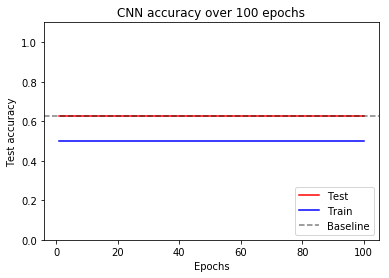

In [247]:
plot_accuracy('simple_cnn.txt','CNN accuracy over 100 epochs')

Over 100 epochs, this simple CNN failed to learn anything and remained at baseline accuracy the whole time. While it is clear that the network is able to accept my data input, a more sophisticated CNN architecture will clearly be required to classify these images.

## <a id='5'>5. Training deep CNNs from scratch</a>

### <a id='5.1'>5.1 ResNet50</a>

#### Model summary

In [78]:
#Import ResNet50 architecture
resmodel = keras.applications.ResNet50(include_top = True, weights=None, classes=2)

In [22]:
resmodel.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        input_2[0][0]                    
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation_50 (Activation)      (None, 112, 112, 64) 0           bn_conv1[0][0]                   
__________________________________________________________________________________________________
max_poolin

#### Training

In [23]:
resmodel.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

In [26]:
#Fit model over 100 epochs
resmodel.fit(X_train_array, y_train_array_k,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_test, y_test_k),
          callbacks=[history])

Train on 2682 samples, validate on 624 samples
Epoch 1/100
2682/2682 [==============================] - 63s 23ms/step - loss: 0.4943 - acc: 0.8382 - val_loss: 3.8362 - val_acc: 0.6250
Epoch 2/100
2682/2682 [==============================] - 47s 18ms/step - loss: 0.2237 - acc: 0.9150 - val_loss: 6.0014 - val_acc: 0.6250
Epoch 3/100
2682/2682 [==============================] - 48s 18ms/step - loss: 0.1774 - acc: 0.9381 - val_loss: 1.9630 - val_acc: 0.6218
Epoch 4/100
2682/2682 [==============================] - 48s 18ms/step - loss: 0.1159 - acc: 0.9564 - val_loss: 0.7959 - val_acc: 0.7083
Epoch 5/100
2682/2682 [==============================] - 48s 18ms/step - loss: 0.1308 - acc: 0.9530 - val_loss: 0.3840 - val_acc: 0.8429
Epoch 6/100
2682/2682 [==============================] - 48s 18ms/step - loss: 0.1062 - acc: 0.9616 - val_loss: 9.9480 - val_acc: 0.3766
Epoch 7/100
2682/2682 [==============================] - 48s 18ms/step - loss: 0.0921 - acc: 0.9605 - val_loss: 9.9180 - val_acc: 0

Epoch 60/100
2682/2682 [==============================] - 48s 18ms/step - loss: 0.0056 - acc: 0.9989 - val_loss: 1.3776 - val_acc: 0.7965
Epoch 61/100
2682/2682 [==============================] - 48s 18ms/step - loss: 0.0037 - acc: 0.9985 - val_loss: 1.3367 - val_acc: 0.8029
Epoch 62/100
2682/2682 [==============================] - 48s 18ms/step - loss: 0.0080 - acc: 0.9952 - val_loss: 1.1601 - val_acc: 0.8269
Epoch 63/100
2682/2682 [==============================] - 48s 18ms/step - loss: 0.0043 - acc: 0.9985 - val_loss: 1.5969 - val_acc: 0.8301
Epoch 64/100
2682/2682 [==============================] - 48s 18ms/step - loss: 0.0271 - acc: 0.9899 - val_loss: 0.8003 - val_acc: 0.8349
Epoch 65/100
2682/2682 [==============================] - 48s 18ms/step - loss: 0.0127 - acc: 0.9944 - val_loss: 5.4957 - val_acc: 0.5016
Epoch 66/100
2682/2682 [==============================] - 48s 18ms/step - loss: 0.0042 - acc: 0.9989 - val_loss: 6.0810 - val_acc: 0.5064
Epoch 67/100
2682/2682 [==========

In [233]:
#Please turn away for a moment while I do some regex trickery to make up for the fact that I didn't log accuracy scores properly
#the first time I ran this.
with open('first_resnet_log.txt', 'r') as myfile:
    data100=myfile.read()

In [234]:
accs_re = '(?<=val_acc:\s)(\d\.\d+)'
trainaccs_re = '(?<=\sacc:\s)(\d\.\d+)'
accs100 = np.array(re.findall(accs_re,data100)).astype(np.float)
trainaccs100 = np.array(re.findall(trainaccs_re,data100)).astype(np.float)
epochs = np.arange(1,101)

Text(0,0.5,'Test accuracy')

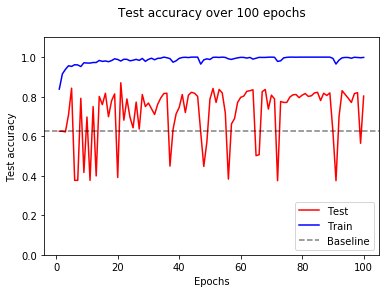

In [235]:
ax = plt.gca()
ax.plot(epochs, accs100, 'r',label='Test')
ax.plot(epochs, trainaccs100, 'b',label='Train')
ax.axhline(y=0.625,color='k',linestyle='dashed',alpha=0.5,label='Baseline')
ax.legend(loc='lower right')
ax.set_ylim([0,1.1])
plt.title('Test accuracy over 100 epochs\n')
plt.xlabel('Epochs')
plt.ylabel('Test accuracy')

In [73]:
#Save the trained model in case I need to use it later
filename = 'resnet100.hdf5'
keras.models.save_model(resmodel, filename)

#### Evaluation

             precision    recall  f1-score   support

          0       0.97      0.49      0.65       234
          1       0.76      0.99      0.86       390

avg / total       0.84      0.80      0.78       624



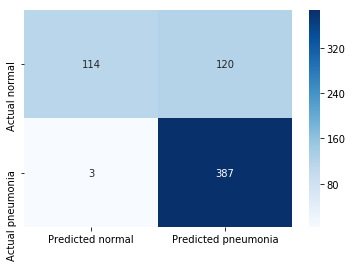

In [63]:
#Evaluate model
res_pred_base = resmodel.predict(X_test)
res_pred = [label_decoder(i) for i in res_pred_base]
res_cm = confusion_matrix(y_test, res_pred)
sns.heatmap(res_cm, annot=True,cmap='Blues',xticklabels = ['Predicted normal','Predicted pneumonia'],
           yticklabels=['Actual normal', 'Actual pneumonia'], fmt='d')
print(classification_report(y_test, res_pred))

             precision    recall  f1-score   support

          0       1.00      0.62      0.77         8
          1       0.73      1.00      0.84         8

avg / total       0.86      0.81      0.81        16



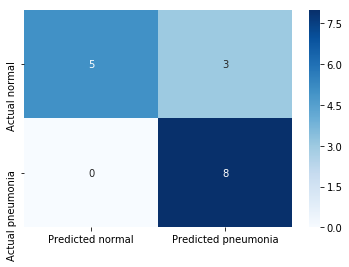

In [62]:
val_pred_base = resmodel.predict(X_val)
val_pred = [label_decoder(i) for i in val_pred_base]
val_cm = confusion_matrix(y_val, val_pred)
sns.heatmap(val_cm, annot=True,cmap='Blues',xticklabels = ['Predicted normal','Predicted pneumonia'],
           yticklabels=['Actual normal', 'Actual pneumonia'], fmt='d')
print(classification_report(y_val, val_pred))

Training a ResNet50 network from scratch using unmodified images actually performs quite well after 100 epochs. I have an accuracy of about 0.8 on the test set. For both the test and validation sets almost all the pneumonia images are correctly classified although there are a significant number of normal images that are being incorrectly classified as pneumonia.

Does training this CNN for 1000 epochs yield better scores?

In [74]:
#Run again with 1000 epochs
resmodel.fit(X_train_array, y_train_array_k,
          batch_size=batch_size,
          epochs=1000,
          verbose=1,
          validation_data=(X_test, y_test_k),
          callbacks=[history])

Train on 2682 samples, validate on 624 samples
Epoch 1/1000
2682/2682 [==============================] - 51s 19ms/step - loss: 0.0023 - acc: 0.9993 - val_loss: 1.8148 - val_acc: 0.7628
Epoch 2/1000
2682/2682 [==============================] - 46s 17ms/step - loss: 0.0026 - acc: 0.9989 - val_loss: 1.5300 - val_acc: 0.7837
Epoch 3/1000
2682/2682 [==============================] - 46s 17ms/step - loss: 9.9974e-04 - acc: 1.0000 - val_loss: 1.5261 - val_acc: 0.7949
Epoch 4/1000
2682/2682 [==============================] - 47s 17ms/step - loss: 2.9534e-04 - acc: 1.0000 - val_loss: 1.9020 - val_acc: 0.7644
Epoch 5/1000
2682/2682 [==============================] - 46s 17ms/step - loss: 1.6350e-04 - acc: 1.0000 - val_loss: 1.7716 - val_acc: 0.7756
Epoch 6/1000
2682/2682 [==============================] - 46s 17ms/step - loss: 1.2805e-04 - acc: 1.0000 - val_loss: 1.7311 - val_acc: 0.7821
Epoch 7/1000
2682/2682 [==============================] - 46s 17ms/step - loss: 1.4333e-04 - acc: 1.0000 - va

2682/2682 [==============================] - 46s 17ms/step - loss: 5.4086e-07 - acc: 1.0000 - val_loss: 1.9742 - val_acc: 0.8077
Epoch 59/1000
2682/2682 [==============================] - 46s 17ms/step - loss: 5.2677e-07 - acc: 1.0000 - val_loss: 2.0429 - val_acc: 0.8029
Epoch 60/1000
2682/2682 [==============================] - 46s 17ms/step - loss: 4.0630e-07 - acc: 1.0000 - val_loss: 2.0127 - val_acc: 0.8029
Epoch 61/1000
2682/2682 [==============================] - 46s 17ms/step - loss: 4.3378e-07 - acc: 1.0000 - val_loss: 1.9933 - val_acc: 0.8045
Epoch 62/1000
2682/2682 [==============================] - 46s 17ms/step - loss: 2.5373e-07 - acc: 1.0000 - val_loss: 1.9876 - val_acc: 0.8045
Epoch 63/1000
2682/2682 [==============================] - 46s 17ms/step - loss: 3.1996e-07 - acc: 1.0000 - val_loss: 2.0090 - val_acc: 0.8045
Epoch 64/1000
2682/2682 [==============================] - 46s 17ms/step - loss: 3.3534e-07 - acc: 1.0000 - val_loss: 2.0677 - val_acc: 0.8013
Epoch 65/1000

2682/2682 [==============================] - 46s 17ms/step - loss: 4.3273e-05 - acc: 1.0000 - val_loss: 1.4325 - val_acc: 0.8157
Epoch 173/1000
2682/2682 [==============================] - 46s 17ms/step - loss: 2.8458e-05 - acc: 1.0000 - val_loss: 1.4695 - val_acc: 0.8125
Epoch 174/1000
2682/2682 [==============================] - 46s 17ms/step - loss: 4.2179e-05 - acc: 1.0000 - val_loss: 1.5310 - val_acc: 0.8093
Epoch 175/1000
2682/2682 [==============================] - 46s 17ms/step - loss: 4.9130e-05 - acc: 1.0000 - val_loss: 1.4903 - val_acc: 0.8109
Epoch 176/1000
2682/2682 [==============================] - 46s 17ms/step - loss: 2.5654e-05 - acc: 1.0000 - val_loss: 1.5384 - val_acc: 0.8125
Epoch 177/1000
2682/2682 [==============================] - 46s 17ms/step - loss: 3.8208e-05 - acc: 1.0000 - val_loss: 1.8324 - val_acc: 0.7901
Epoch 178/1000
2682/2682 [==============================] - 46s 17ms/step - loss: 4.6722e-05 - acc: 1.0000 - val_loss: 1.7142 - val_acc: 0.8045
Epoch 1

2682/2682 [==============================] - 46s 17ms/step - loss: 7.9675e-06 - acc: 1.0000 - val_loss: 1.7298 - val_acc: 0.8237
Epoch 287/1000
2682/2682 [==============================] - 46s 17ms/step - loss: 9.6876e-06 - acc: 1.0000 - val_loss: 1.7704 - val_acc: 0.8189
Epoch 288/1000
2682/2682 [==============================] - 46s 17ms/step - loss: 1.4528e-05 - acc: 1.0000 - val_loss: 1.8724 - val_acc: 0.8109
Epoch 289/1000
2682/2682 [==============================] - 46s 17ms/step - loss: 4.7703e-06 - acc: 1.0000 - val_loss: 1.8146 - val_acc: 0.8141
Epoch 290/1000
2682/2682 [==============================] - 46s 17ms/step - loss: 8.3936e-06 - acc: 1.0000 - val_loss: 1.7387 - val_acc: 0.8221
Epoch 291/1000
2682/2682 [==============================] - 46s 17ms/step - loss: 5.9903e-06 - acc: 1.0000 - val_loss: 1.8289 - val_acc: 0.8173
Epoch 292/1000
2682/2682 [==============================] - 46s 17ms/step - loss: 9.3256e-06 - acc: 1.0000 - val_loss: 1.7834 - val_acc: 0.8173
Epoch 2

2682/2682 [==============================] - 46s 17ms/step - loss: 6.6289e-05 - acc: 1.0000 - val_loss: 1.7244 - val_acc: 0.8093
Epoch 401/1000
2682/2682 [==============================] - 46s 17ms/step - loss: 4.0092e-05 - acc: 1.0000 - val_loss: 1.7157 - val_acc: 0.8109
Epoch 402/1000
2682/2682 [==============================] - 46s 17ms/step - loss: 3.9260e-05 - acc: 1.0000 - val_loss: 1.7286 - val_acc: 0.8093
Epoch 403/1000
2682/2682 [==============================] - 46s 17ms/step - loss: 2.9189e-05 - acc: 1.0000 - val_loss: 1.7303 - val_acc: 0.8109
Epoch 404/1000
2682/2682 [==============================] - 46s 17ms/step - loss: 0.0107 - acc: 0.9966 - val_loss: 2.6595 - val_acc: 0.7131
Epoch 405/1000
2682/2682 [==============================] - 46s 17ms/step - loss: 0.0117 - acc: 0.9966 - val_loss: 3.0173 - val_acc: 0.6138
Epoch 406/1000
2682/2682 [==============================] - 46s 17ms/step - loss: 0.0048 - acc: 0.9985 - val_loss: 1.6814 - val_acc: 0.8285
Epoch 407/1000
2682

2682/2682 [==============================] - 46s 17ms/step - loss: 8.9093e-05 - acc: 1.0000 - val_loss: 2.0665 - val_acc: 0.7949
Epoch 515/1000
2682/2682 [==============================] - 46s 17ms/step - loss: 3.6557e-05 - acc: 1.0000 - val_loss: 2.0245 - val_acc: 0.7965
Epoch 516/1000
2682/2682 [==============================] - 46s 17ms/step - loss: 8.1078e-05 - acc: 1.0000 - val_loss: 2.1643 - val_acc: 0.7933
Epoch 517/1000
2682/2682 [==============================] - 46s 17ms/step - loss: 3.3601e-05 - acc: 1.0000 - val_loss: 2.0701 - val_acc: 0.7965
Epoch 518/1000
2682/2682 [==============================] - 46s 17ms/step - loss: 1.0713e-05 - acc: 1.0000 - val_loss: 2.0502 - val_acc: 0.7965
Epoch 519/1000
2682/2682 [==============================] - 46s 17ms/step - loss: 2.2257e-04 - acc: 1.0000 - val_loss: 1.9327 - val_acc: 0.8029
Epoch 520/1000
2682/2682 [==============================] - 46s 17ms/step - loss: 2.7265e-05 - acc: 1.0000 - val_loss: 1.9841 - val_acc: 0.8029
Epoch 5

2682/2682 [==============================] - 46s 17ms/step - loss: 2.0549e-06 - acc: 1.0000 - val_loss: 2.1654 - val_acc: 0.7869
Epoch 629/1000
2682/2682 [==============================] - 46s 17ms/step - loss: 3.3732e-06 - acc: 1.0000 - val_loss: 2.1485 - val_acc: 0.7869
Epoch 630/1000
2682/2682 [==============================] - 46s 17ms/step - loss: 2.8015e-06 - acc: 1.0000 - val_loss: 2.1278 - val_acc: 0.7901
Epoch 631/1000
2682/2682 [==============================] - 46s 17ms/step - loss: 4.0068e-06 - acc: 1.0000 - val_loss: 2.2308 - val_acc: 0.7821
Epoch 632/1000
2682/2682 [==============================] - 46s 17ms/step - loss: 4.2457e-06 - acc: 1.0000 - val_loss: 2.1840 - val_acc: 0.7821
Epoch 633/1000
2682/2682 [==============================] - 46s 17ms/step - loss: 1.5600e-06 - acc: 1.0000 - val_loss: 2.1257 - val_acc: 0.7917
Epoch 634/1000
2682/2682 [==============================] - 46s 17ms/step - loss: 3.0686e-06 - acc: 1.0000 - val_loss: 2.1745 - val_acc: 0.7853
Epoch 6

2682/2682 [==============================] - 46s 17ms/step - loss: 1.9804e-06 - acc: 1.0000 - val_loss: 1.9320 - val_acc: 0.8189
Epoch 686/1000
2682/2682 [==============================] - 46s 17ms/step - loss: 2.0032e-06 - acc: 1.0000 - val_loss: 1.9216 - val_acc: 0.8205
Epoch 687/1000
2682/2682 [==============================] - 46s 17ms/step - loss: 1.1666e-06 - acc: 1.0000 - val_loss: 1.9208 - val_acc: 0.8221
Epoch 688/1000
2682/2682 [==============================] - 46s 17ms/step - loss: 1.8328e-06 - acc: 1.0000 - val_loss: 1.9534 - val_acc: 0.8189
Epoch 689/1000
2682/2682 [==============================] - 46s 17ms/step - loss: 1.3682e-06 - acc: 1.0000 - val_loss: 1.9336 - val_acc: 0.8205
Epoch 690/1000
2682/2682 [==============================] - 46s 17ms/step - loss: 1.2624e-06 - acc: 1.0000 - val_loss: 1.9040 - val_acc: 0.8237
Epoch 691/1000
2682/2682 [==============================] - 46s 17ms/step - loss: 1.1646e-06 - acc: 1.0000 - val_loss: 1.9508 - val_acc: 0.8205
Epoch 6

2682/2682 [==============================] - 46s 17ms/step - loss: 7.0327e-06 - acc: 1.0000 - val_loss: 2.0970 - val_acc: 0.7981
Epoch 743/1000
2682/2682 [==============================] - 46s 17ms/step - loss: 6.7058e-04 - acc: 0.9993 - val_loss: 3.1218 - val_acc: 0.7308
Epoch 744/1000
2682/2682 [==============================] - 46s 17ms/step - loss: 5.9352e-04 - acc: 0.9996 - val_loss: 1.7505 - val_acc: 0.8221
Epoch 745/1000
2682/2682 [==============================] - 46s 17ms/step - loss: 6.4432e-04 - acc: 1.0000 - val_loss: 2.1634 - val_acc: 0.8061
Epoch 746/1000
2682/2682 [==============================] - 46s 17ms/step - loss: 3.3822e-05 - acc: 1.0000 - val_loss: 2.2656 - val_acc: 0.8029
Epoch 747/1000
2682/2682 [==============================] - 46s 17ms/step - loss: 1.9169e-05 - acc: 1.0000 - val_loss: 2.2249 - val_acc: 0.8061
Epoch 748/1000
2682/2682 [==============================] - 46s 17ms/step - loss: 2.2532e-05 - acc: 1.0000 - val_loss: 2.4117 - val_acc: 0.7981
Epoch 7

Epoch 799/1000
2682/2682 [==============================] - 46s 17ms/step - loss: 2.1868e-07 - acc: 1.0000 - val_loss: 2.2995 - val_acc: 0.7997
Epoch 800/1000
2682/2682 [==============================] - 46s 17ms/step - loss: 2.0348e-07 - acc: 1.0000 - val_loss: 2.3139 - val_acc: 0.8013
Epoch 801/1000
2682/2682 [==============================] - 46s 17ms/step - loss: 1.9444e-07 - acc: 1.0000 - val_loss: 2.3129 - val_acc: 0.7997
Epoch 802/1000
2682/2682 [==============================] - 47s 17ms/step - loss: 2.0344e-07 - acc: 1.0000 - val_loss: 2.2966 - val_acc: 0.7997
Epoch 803/1000
2682/2682 [==============================] - 46s 17ms/step - loss: 4.2158e-07 - acc: 1.0000 - val_loss: 2.3894 - val_acc: 0.8013
Epoch 804/1000
2682/2682 [==============================] - 46s 17ms/step - loss: 2.8436e-07 - acc: 1.0000 - val_loss: 2.3568 - val_acc: 0.8029
Epoch 805/1000
2682/2682 [==============================] - 46s 17ms/step - loss: 1.8168e-07 - acc: 1.0000 - val_loss: 2.3342 - val_acc:

2682/2682 [==============================] - 46s 17ms/step - loss: 3.9280e-07 - acc: 1.0000 - val_loss: 2.4053 - val_acc: 0.7997
Epoch 857/1000
2682/2682 [==============================] - 46s 17ms/step - loss: 3.5601e-07 - acc: 1.0000 - val_loss: 2.4090 - val_acc: 0.7997
Epoch 858/1000
2682/2682 [==============================] - 46s 17ms/step - loss: 1.9824e-06 - acc: 1.0000 - val_loss: 2.4873 - val_acc: 0.7965
Epoch 859/1000
2682/2682 [==============================] - 46s 17ms/step - loss: 9.1754e-06 - acc: 1.0000 - val_loss: 2.7290 - val_acc: 0.7804
Epoch 860/1000
2682/2682 [==============================] - 46s 17ms/step - loss: 3.4265e-06 - acc: 1.0000 - val_loss: 2.5696 - val_acc: 0.7821
Epoch 861/1000
2682/2682 [==============================] - 46s 17ms/step - loss: 1.9344e-06 - acc: 1.0000 - val_loss: 2.5764 - val_acc: 0.7821
Epoch 862/1000
2682/2682 [==============================] - 46s 17ms/step - loss: 5.5209e-07 - acc: 1.0000 - val_loss: 2.5209 - val_acc: 0.7869
Epoch 8

2682/2682 [==============================] - 46s 17ms/step - loss: 1.0410e-06 - acc: 1.0000 - val_loss: 2.1378 - val_acc: 0.8237
Epoch 971/1000
2682/2682 [==============================] - 46s 17ms/step - loss: 3.3823e-07 - acc: 1.0000 - val_loss: 2.1347 - val_acc: 0.8237
Epoch 972/1000
2682/2682 [==============================] - 46s 17ms/step - loss: 3.1820e-06 - acc: 1.0000 - val_loss: 2.1767 - val_acc: 0.8189
Epoch 973/1000
2682/2682 [==============================] - 46s 17ms/step - loss: 1.0025e-06 - acc: 1.0000 - val_loss: 2.1656 - val_acc: 0.8205
Epoch 974/1000
2682/2682 [==============================] - 46s 17ms/step - loss: 6.9651e-07 - acc: 1.0000 - val_loss: 2.1588 - val_acc: 0.8205
Epoch 975/1000
2682/2682 [==============================] - 46s 17ms/step - loss: 2.6771e-06 - acc: 1.0000 - val_loss: 2.1787 - val_acc: 0.8189
Epoch 976/1000
2682/2682 [==============================] - 46s 17ms/step - loss: 5.8673e-07 - acc: 1.0000 - val_loss: 2.1702 - val_acc: 0.8237
Epoch 9

Text(0,0.5,'Test accuracy')

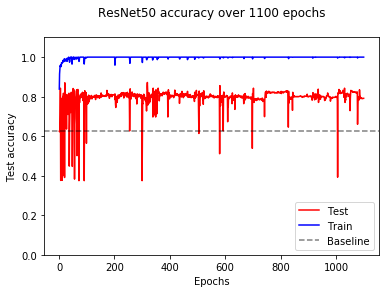

In [238]:
with open('first_resnet1000.txt', 'r') as myfile:
    data1000=myfile.read()
accs_re = '(?<=val_acc:\s)(\d\.\d+)'
trainaccs_re = '(?<=\sacc:\s)(\d\.\d+)'
accs1000 = np.array(re.findall(accs_re,data1000)).astype(np.float)
trainaccs1000 = np.array(re.findall(trainaccs_re,data1000)).astype(np.float)
trainaccs = np.append(trainaccs100, trainaccs1000)
accs = np.append(accs100, accs1000)
epochs = np.arange(1,1101)
ax = plt.gca()
ax.plot(epochs, accs, 'r', label='Test')
ax.plot(epochs, trainaccs, 'b', label='Train')
ax.axhline(y=0.625,color='k',linestyle='dashed',alpha=0.5,label='Baseline')
ax.legend(loc='lower right')
ax.set_ylim([0,1.1])
plt.title('ResNet50 accuracy over 1100 epochs\n')
plt.xlabel('Epochs')
plt.ylabel('Test accuracy')

             precision    recall  f1-score   support

          0       0.96      0.47      0.63       234
          1       0.75      0.99      0.86       390

avg / total       0.83      0.79      0.77       624



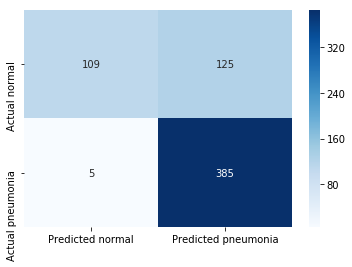

In [75]:
res_pred_base = resmodel.predict(X_test)
res_pred = [label_decoder(i) for i in res_pred_base]
res_cm = confusion_matrix(y_test, res_pred)
sns.heatmap(res_cm, annot=True,cmap='Blues',xticklabels = ['Predicted normal','Predicted pneumonia'],
           yticklabels=['Actual normal', 'Actual pneumonia'], fmt='d')
print(classification_report(y_test, res_pred))

             precision    recall  f1-score   support

          0       1.00      0.88      0.93         8
          1       0.89      1.00      0.94         8

avg / total       0.94      0.94      0.94        16



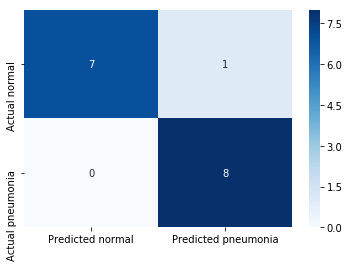

In [76]:
val_pred_base = resmodel.predict(X_val)
val_pred = [label_decoder(i) for i in val_pred_base]
val_cm = confusion_matrix(y_val, val_pred)
sns.heatmap(val_cm, annot=True,cmap='Blues',xticklabels = ['Predicted normal','Predicted pneumonia'],
           yticklabels=['Actual normal', 'Actual pneumonia'], fmt='d')
print(classification_report(y_val, val_pred))

Training for an additional 1000 epochs does not greatly improve the accuracy score for the test set. However, accuracy and f1-score for the validation set are significantly improved with close to 0.94 for both accuracy and f1-score on this set.

In [77]:
print('test set accuracy: ', accuracy_score(y_test, res_pred))
print('validation set accuracy: ', accuracy_score(y_val, val_pred))

test set accuracy:  0.7916666666666666
validation set accuracy:  0.9375


In [78]:
#Save the trained model in case I need to use it later
filename = 'resnet1000.hdf5'
keras.models.save_model(resmodel, filename)

#### Training using standardised images

This model was trained on non-standardised images. Does standardising the pixel values of the images improve performance?

In [21]:
#Fit with standardised images
resmodel2 = keras.applications.ResNet50(include_top = True, weights=None, classes=2)

In [22]:
resmodel2.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

In [25]:
resmodel2.fit(X_train_array, y_train_array_k,
          batch_size=16,
          epochs=1000,
          verbose=1,
          validation_data=(X_test, y_test_k),
          callbacks=[history])

Train on 2682 samples, validate on 624 samples
Epoch 1/1000
2682/2682 [==============================] - 79s 30ms/step - loss: 0.3613 - acc: 0.8740 - val_loss: 3.4064 - val_acc: 0.6250
Epoch 2/1000
2682/2682 [==============================] - 46s 17ms/step - loss: 0.2196 - acc: 0.9131 - val_loss: 2.3995 - val_acc: 0.6250
Epoch 3/1000
2682/2682 [==============================] - 46s 17ms/step - loss: 0.1425 - acc: 0.9467 - val_loss: 1.5559 - val_acc: 0.6266
Epoch 4/1000
2682/2682 [==============================] - 46s 17ms/step - loss: 0.1458 - acc: 0.9437 - val_loss: 5.1186 - val_acc: 0.6250
Epoch 5/1000
2682/2682 [==============================] - 46s 17ms/step - loss: 0.1308 - acc: 0.9538 - val_loss: 2.6458 - val_acc: 0.6298
Epoch 6/1000
2682/2682 [==============================] - 46s 17ms/step - loss: 0.1253 - acc: 0.9590 - val_loss: 1.0943 - val_acc: 0.6987
Epoch 7/1000
2682/2682 [==============================] - 46s 17ms/step - loss: 0.1167 - acc: 0.9575 - val_loss: 0.9307 - val

2682/2682 [==============================] - 46s 17ms/step - loss: 0.0232 - acc: 0.9903 - val_loss: 3.0863 - val_acc: 0.6538
Epoch 118/1000
2682/2682 [==============================] - 46s 17ms/step - loss: 0.0068 - acc: 0.9970 - val_loss: 1.1501 - val_acc: 0.7676
Epoch 119/1000
2682/2682 [==============================] - 46s 17ms/step - loss: 0.0015 - acc: 1.0000 - val_loss: 2.1017 - val_acc: 0.6875
Epoch 120/1000
2682/2682 [==============================] - 46s 17ms/step - loss: 6.9103e-04 - acc: 1.0000 - val_loss: 2.1732 - val_acc: 0.7051
Epoch 121/1000
2682/2682 [==============================] - 46s 17ms/step - loss: 0.0016 - acc: 0.9993 - val_loss: 2.2005 - val_acc: 0.6971
Epoch 122/1000
2682/2682 [==============================] - 46s 17ms/step - loss: 6.8206e-04 - acc: 1.0000 - val_loss: 2.2996 - val_acc: 0.6875
Epoch 123/1000
2682/2682 [==============================] - 46s 17ms/step - loss: 5.1836e-04 - acc: 1.0000 - val_loss: 2.8277 - val_acc: 0.6763
Epoch 124/1000
2682/268

2682/2682 [==============================] - 46s 17ms/step - loss: 1.8182e-05 - acc: 1.0000 - val_loss: 3.3712 - val_acc: 0.6683
Epoch 232/1000
2682/2682 [==============================] - 46s 17ms/step - loss: 4.5376e-05 - acc: 1.0000 - val_loss: 3.7594 - val_acc: 0.6587
Epoch 233/1000
2682/2682 [==============================] - 46s 17ms/step - loss: 2.0754e-05 - acc: 1.0000 - val_loss: 3.6174 - val_acc: 0.6587
Epoch 234/1000
2682/2682 [==============================] - 46s 17ms/step - loss: 8.3853e-06 - acc: 1.0000 - val_loss: 3.6085 - val_acc: 0.6587
Epoch 235/1000
2682/2682 [==============================] - 46s 17ms/step - loss: 1.0571e-05 - acc: 1.0000 - val_loss: 3.6028 - val_acc: 0.6587
Epoch 236/1000
2682/2682 [==============================] - 46s 17ms/step - loss: 1.3119e-05 - acc: 1.0000 - val_loss: 3.4916 - val_acc: 0.6619
Epoch 237/1000
2682/2682 [==============================] - 46s 17ms/step - loss: 1.0165e-05 - acc: 1.0000 - val_loss: 3.5983 - val_acc: 0.6587
Epoch 2

2682/2682 [==============================] - 46s 17ms/step - loss: 4.3013e-06 - acc: 1.0000 - val_loss: 2.9992 - val_acc: 0.7196
Epoch 346/1000
2682/2682 [==============================] - 46s 17ms/step - loss: 3.2212e-06 - acc: 1.0000 - val_loss: 2.9817 - val_acc: 0.7179
Epoch 347/1000
2682/2682 [==============================] - 46s 17ms/step - loss: 3.7963e-06 - acc: 1.0000 - val_loss: 3.0010 - val_acc: 0.7196
Epoch 348/1000
2682/2682 [==============================] - 46s 17ms/step - loss: 2.3025e-06 - acc: 1.0000 - val_loss: 2.9737 - val_acc: 0.7179
Epoch 349/1000
2682/2682 [==============================] - 46s 17ms/step - loss: 3.1593e-06 - acc: 1.0000 - val_loss: 3.0425 - val_acc: 0.7196
Epoch 350/1000
2682/2682 [==============================] - 46s 17ms/step - loss: 2.9965e-06 - acc: 1.0000 - val_loss: 3.0212 - val_acc: 0.7196
Epoch 351/1000
2682/2682 [==============================] - 46s 17ms/step - loss: 2.8379e-06 - acc: 1.0000 - val_loss: 3.0740 - val_acc: 0.7196
Epoch 3

2682/2682 [==============================] - 46s 17ms/step - loss: 4.7878e-07 - acc: 1.0000 - val_loss: 3.7200 - val_acc: 0.6971
Epoch 460/1000
2682/2682 [==============================] - 46s 17ms/step - loss: 4.2556e-07 - acc: 1.0000 - val_loss: 3.7173 - val_acc: 0.6971
Epoch 461/1000
2682/2682 [==============================] - 46s 17ms/step - loss: 5.3104e-07 - acc: 1.0000 - val_loss: 3.7466 - val_acc: 0.6971
Epoch 462/1000
2682/2682 [==============================] - 46s 17ms/step - loss: 1.0341e-06 - acc: 1.0000 - val_loss: 3.6754 - val_acc: 0.7019
Epoch 463/1000
2682/2682 [==============================] - 46s 17ms/step - loss: 3.8046e-07 - acc: 1.0000 - val_loss: 3.6814 - val_acc: 0.6987
Epoch 464/1000
2682/2682 [==============================] - 46s 17ms/step - loss: 4.9497e-07 - acc: 1.0000 - val_loss: 3.6441 - val_acc: 0.7019
Epoch 465/1000
2682/2682 [==============================] - 46s 17ms/step - loss: 2.8329e-07 - acc: 1.0000 - val_loss: 3.6467 - val_acc: 0.7019
Epoch 4

2682/2682 [==============================] - 46s 17ms/step - loss: 4.9933e-06 - acc: 1.0000 - val_loss: 3.6927 - val_acc: 0.6875
Epoch 574/1000
2682/2682 [==============================] - 46s 17ms/step - loss: 8.9694e-06 - acc: 1.0000 - val_loss: 3.6938 - val_acc: 0.6875
Epoch 575/1000
2682/2682 [==============================] - 46s 17ms/step - loss: 1.1093e-05 - acc: 1.0000 - val_loss: 3.6497 - val_acc: 0.6923
Epoch 576/1000
2682/2682 [==============================] - 46s 17ms/step - loss: 5.8488e-06 - acc: 1.0000 - val_loss: 3.7095 - val_acc: 0.6875
Epoch 577/1000
2682/2682 [==============================] - 46s 17ms/step - loss: 6.3373e-06 - acc: 1.0000 - val_loss: 3.6493 - val_acc: 0.6923
Epoch 578/1000
2682/2682 [==============================] - 46s 17ms/step - loss: 5.0831e-06 - acc: 1.0000 - val_loss: 3.6421 - val_acc: 0.6923
Epoch 579/1000
2682/2682 [==============================] - 46s 17ms/step - loss: 8.5055e-06 - acc: 1.0000 - val_loss: 3.6903 - val_acc: 0.6907
Epoch 5

Epoch 630/1000
2682/2682 [==============================] - 46s 17ms/step - loss: 2.8284e-07 - acc: 1.0000 - val_loss: 3.8613 - val_acc: 0.6891
Epoch 631/1000
2682/2682 [==============================] - 46s 17ms/step - loss: 5.5857e-07 - acc: 1.0000 - val_loss: 4.0636 - val_acc: 0.6811
Epoch 632/1000
2682/2682 [==============================] - 46s 17ms/step - loss: 3.1105e-07 - acc: 1.0000 - val_loss: 3.9551 - val_acc: 0.6843
Epoch 633/1000
2682/2682 [==============================] - 46s 17ms/step - loss: 1.1579e-06 - acc: 1.0000 - val_loss: 3.7602 - val_acc: 0.6923
Epoch 634/1000
2682/2682 [==============================] - 46s 17ms/step - loss: 0.0246 - acc: 0.9948 - val_loss: 2.4922 - val_acc: 0.7468
Epoch 635/1000
2682/2682 [==============================] - 46s 17ms/step - loss: 0.0066 - acc: 0.9974 - val_loss: 2.6168 - val_acc: 0.7276
Epoch 636/1000
2682/2682 [==============================] - 46s 17ms/step - loss: 0.0013 - acc: 0.9993 - val_loss: 3.7807 - val_acc: 0.6715
Epoc

2682/2682 [==============================] - 46s 17ms/step - loss: 3.2645e-05 - acc: 1.0000 - val_loss: 3.1859 - val_acc: 0.6971
Epoch 688/1000
2682/2682 [==============================] - 46s 17ms/step - loss: 1.2362e-04 - acc: 1.0000 - val_loss: 3.2571 - val_acc: 0.7003
Epoch 689/1000
2682/2682 [==============================] - 46s 17ms/step - loss: 6.5739e-06 - acc: 1.0000 - val_loss: 3.2939 - val_acc: 0.7019
Epoch 690/1000
2682/2682 [==============================] - 46s 17ms/step - loss: 2.6909e-06 - acc: 1.0000 - val_loss: 3.3114 - val_acc: 0.7019
Epoch 691/1000
2682/2682 [==============================] - 46s 17ms/step - loss: 2.3911e-06 - acc: 1.0000 - val_loss: 3.3348 - val_acc: 0.7019
Epoch 692/1000
2682/2682 [==============================] - 46s 17ms/step - loss: 3.0575e-06 - acc: 1.0000 - val_loss: 3.3370 - val_acc: 0.7019
Epoch 693/1000
2682/2682 [==============================] - 46s 17ms/step - loss: 2.0141e-06 - acc: 1.0000 - val_loss: 3.3515 - val_acc: 0.7019
Epoch 6

Epoch 744/1000
2682/2682 [==============================] - 46s 17ms/step - loss: 1.4103e-07 - acc: 1.0000 - val_loss: 3.7647 - val_acc: 0.6987
Epoch 745/1000
2682/2682 [==============================] - 46s 17ms/step - loss: 1.7775e-07 - acc: 1.0000 - val_loss: 3.7948 - val_acc: 0.6971
Epoch 746/1000
2682/2682 [==============================] - 46s 17ms/step - loss: 1.7308e-07 - acc: 1.0000 - val_loss: 3.7680 - val_acc: 0.7003
Epoch 747/1000
2682/2682 [==============================] - 46s 17ms/step - loss: 1.5337e-07 - acc: 1.0000 - val_loss: 3.7674 - val_acc: 0.7003
Epoch 748/1000
2682/2682 [==============================] - 46s 17ms/step - loss: 1.4955e-07 - acc: 1.0000 - val_loss: 3.7866 - val_acc: 0.6971
Epoch 749/1000
2682/2682 [==============================] - 46s 17ms/step - loss: 1.4463e-07 - acc: 1.0000 - val_loss: 3.7758 - val_acc: 0.6971
Epoch 750/1000
2682/2682 [==============================] - 46s 17ms/step - loss: 1.4457e-07 - acc: 1.0000 - val_loss: 3.7494 - val_acc:

Epoch 801/1000
2682/2682 [==============================] - 46s 17ms/step - loss: 4.5327e-07 - acc: 1.0000 - val_loss: 3.9169 - val_acc: 0.6891
Epoch 802/1000
2682/2682 [==============================] - 46s 17ms/step - loss: 3.3633e-07 - acc: 1.0000 - val_loss: 3.9434 - val_acc: 0.6859
Epoch 803/1000
2682/2682 [==============================] - 46s 17ms/step - loss: 2.1309e-07 - acc: 1.0000 - val_loss: 3.9072 - val_acc: 0.6891
Epoch 804/1000
2682/2682 [==============================] - 46s 17ms/step - loss: 4.7221e-07 - acc: 1.0000 - val_loss: 3.9031 - val_acc: 0.6891
Epoch 805/1000
2682/2682 [==============================] - 46s 17ms/step - loss: 2.5505e-06 - acc: 1.0000 - val_loss: 3.9828 - val_acc: 0.6827
Epoch 806/1000
2682/2682 [==============================] - 46s 17ms/step - loss: 1.2844e-06 - acc: 1.0000 - val_loss: 3.9351 - val_acc: 0.6875
Epoch 807/1000
2682/2682 [==============================] - 46s 17ms/step - loss: 4.4227e-06 - acc: 1.0000 - val_loss: 4.0226 - val_acc:

2682/2682 [==============================] - 46s 17ms/step - loss: 1.2304e-06 - acc: 1.0000 - val_loss: 3.3981 - val_acc: 0.7196
Epoch 916/1000
2682/2682 [==============================] - 46s 17ms/step - loss: 1.9385e-06 - acc: 1.0000 - val_loss: 3.4113 - val_acc: 0.7196
Epoch 917/1000
2682/2682 [==============================] - 46s 17ms/step - loss: 1.3412e-06 - acc: 1.0000 - val_loss: 3.4222 - val_acc: 0.7196
Epoch 918/1000
2682/2682 [==============================] - 46s 17ms/step - loss: 1.1750e-06 - acc: 1.0000 - val_loss: 3.4353 - val_acc: 0.7196
Epoch 919/1000
2682/2682 [==============================] - 46s 17ms/step - loss: 6.0236e-07 - acc: 1.0000 - val_loss: 3.4247 - val_acc: 0.7196
Epoch 920/1000
2682/2682 [==============================] - 46s 17ms/step - loss: 4.6467e-07 - acc: 1.0000 - val_loss: 3.4031 - val_acc: 0.7212
Epoch 921/1000
2682/2682 [==============================] - 46s 17ms/step - loss: 0.0161 - acc: 0.9963 - val_loss: 4.3945 - val_acc: 0.6651
Epoch 922/1

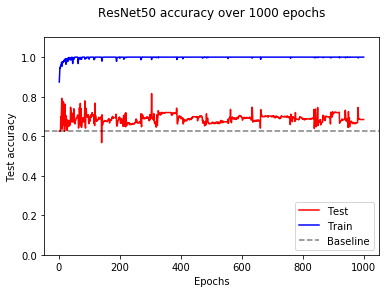

In [239]:
plot_accuracy('std_resnet.txt','ResNet50 accuracy over 1000 epochs\n')

             precision    recall  f1-score   support

          0       1.00      0.16      0.27       234
          1       0.66      1.00      0.80       390

avg / total       0.79      0.68      0.60       624



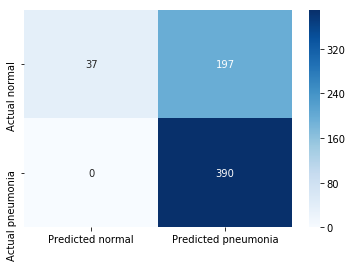

In [26]:
res2_pred_base = resmodel2.predict(X_test)
res2_pred = [label_decoder(i) for i in res2_pred_base]
res2_cm = confusion_matrix(y_test, res2_pred)
sns.heatmap(res2_cm, annot=True,cmap='Blues',xticklabels = ['Predicted normal','Predicted pneumonia'],
           yticklabels=['Actual normal', 'Actual pneumonia'], fmt='d')
print(classification_report(y_test, res2_pred))

Interestingly, scaling the images using StandardScaler actually reduces the model accuracy and F1 score compared to the unmodified images.

### <a id='5.2'>5.2 InceptionV3</a>

#### Model summary

In [27]:
incmodel = keras.applications.InceptionV3(weights=None, classes=2, input_shape=(224,224,3))

In [28]:
incmodel.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 111, 111, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 111, 111, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 111, 111, 32) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [29]:
incmodel.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

In [31]:
incmodel.fit(X_train_array, y_train_array_k,
          batch_size=batch_size,
          epochs=1000,
          verbose=1,
          validation_data=(X_test, y_test_k),
          callbacks=[history])

Train on 2682 samples, validate on 624 samples
Epoch 1/1000
2682/2682 [==============================] - 35s 13ms/step - loss: 0.0682 - acc: 0.9720 - val_loss: 0.7960 - val_acc: 0.7901
Epoch 2/1000
2682/2682 [==============================] - 35s 13ms/step - loss: 0.0550 - acc: 0.9799 - val_loss: 1.9990 - val_acc: 0.6859
Epoch 3/1000
2682/2682 [==============================] - 35s 13ms/step - loss: 0.0691 - acc: 0.9758 - val_loss: 0.8199 - val_acc: 0.7324
Epoch 4/1000
2682/2682 [==============================] - 35s 13ms/step - loss: 0.0433 - acc: 0.9828 - val_loss: 2.2192 - val_acc: 0.6587
Epoch 5/1000
2682/2682 [==============================] - 35s 13ms/step - loss: 0.0395 - acc: 0.9873 - val_loss: 0.7864 - val_acc: 0.8253
Epoch 6/1000
2682/2682 [==============================] - 35s 13ms/step - loss: 0.0206 - acc: 0.9922 - val_loss: 1.1723 - val_acc: 0.7965
Epoch 7/1000
2682/2682 [==============================] - 35s 13ms/step - loss: 0.0286 - acc: 0.9922 - val_loss: 1.5566 - val

Epoch 117/1000
2682/2682 [==============================] - 35s 13ms/step - loss: 0.0064 - acc: 0.9981 - val_loss: 0.6132 - val_acc: 0.8734
Epoch 118/1000
2682/2682 [==============================] - 35s 13ms/step - loss: 0.0184 - acc: 0.9922 - val_loss: 2.2716 - val_acc: 0.7260
Epoch 119/1000
2682/2682 [==============================] - 35s 13ms/step - loss: 0.0019 - acc: 0.9996 - val_loss: 1.4222 - val_acc: 0.8029
Epoch 120/1000
2682/2682 [==============================] - 35s 13ms/step - loss: 0.0016 - acc: 0.9993 - val_loss: 1.6177 - val_acc: 0.7804
Epoch 121/1000
2682/2682 [==============================] - 35s 13ms/step - loss: 3.6668e-04 - acc: 1.0000 - val_loss: 2.0544 - val_acc: 0.7404
Epoch 122/1000
2682/2682 [==============================] - 35s 13ms/step - loss: 2.2327e-04 - acc: 1.0000 - val_loss: 1.5917 - val_acc: 0.7917
Epoch 123/1000
2682/2682 [==============================] - 35s 13ms/step - loss: 5.8529e-05 - acc: 1.0000 - val_loss: 1.5158 - val_acc: 0.7997
Epoch 12

2682/2682 [==============================] - 35s 13ms/step - loss: 4.0391e-05 - acc: 1.0000 - val_loss: 1.6365 - val_acc: 0.8045
Epoch 232/1000
2682/2682 [==============================] - 35s 13ms/step - loss: 1.8496e-04 - acc: 1.0000 - val_loss: 1.7409 - val_acc: 0.8077
Epoch 233/1000
2682/2682 [==============================] - 35s 13ms/step - loss: 0.0138 - acc: 0.9952 - val_loss: 1.1822 - val_acc: 0.8077
Epoch 234/1000
2682/2682 [==============================] - 35s 13ms/step - loss: 0.0083 - acc: 0.9970 - val_loss: 1.9015 - val_acc: 0.7821
Epoch 235/1000
2682/2682 [==============================] - 35s 13ms/step - loss: 0.0063 - acc: 0.9978 - val_loss: 1.6958 - val_acc: 0.7933
Epoch 236/1000
2682/2682 [==============================] - 35s 13ms/step - loss: 9.9005e-04 - acc: 0.9996 - val_loss: 1.3390 - val_acc: 0.8221
Epoch 237/1000
2682/2682 [==============================] - 35s 13ms/step - loss: 2.0940e-04 - acc: 1.0000 - val_loss: 1.5129 - val_acc: 0.8109
Epoch 238/1000
2682

2682/2682 [==============================] - 35s 13ms/step - loss: 1.6145e-04 - acc: 1.0000 - val_loss: 1.6377 - val_acc: 0.8061
Epoch 346/1000
2682/2682 [==============================] - 35s 13ms/step - loss: 2.9382e-05 - acc: 1.0000 - val_loss: 1.5993 - val_acc: 0.8141
Epoch 347/1000
2682/2682 [==============================] - 35s 13ms/step - loss: 4.2315e-05 - acc: 1.0000 - val_loss: 1.6154 - val_acc: 0.8141
Epoch 348/1000
2682/2682 [==============================] - 35s 13ms/step - loss: 3.7449e-05 - acc: 1.0000 - val_loss: 1.6035 - val_acc: 0.8157
Epoch 349/1000
2682/2682 [==============================] - 35s 13ms/step - loss: 1.5192e-05 - acc: 1.0000 - val_loss: 1.5597 - val_acc: 0.8189
Epoch 350/1000
2682/2682 [==============================] - 35s 13ms/step - loss: 2.8562e-05 - acc: 1.0000 - val_loss: 1.5821 - val_acc: 0.8189
Epoch 351/1000
2682/2682 [==============================] - 35s 13ms/step - loss: 6.3920e-05 - acc: 1.0000 - val_loss: 1.7008 - val_acc: 0.8093
Epoch 3

Epoch 402/1000
2682/2682 [==============================] - 35s 13ms/step - loss: 1.0580e-06 - acc: 1.0000 - val_loss: 2.0223 - val_acc: 0.8173
Epoch 403/1000
2682/2682 [==============================] - 35s 13ms/step - loss: 2.3555e-07 - acc: 1.0000 - val_loss: 2.0819 - val_acc: 0.8157
Epoch 404/1000
2682/2682 [==============================] - 35s 13ms/step - loss: 3.7482e-07 - acc: 1.0000 - val_loss: 2.0724 - val_acc: 0.8157
Epoch 405/1000
2682/2682 [==============================] - 35s 13ms/step - loss: 2.3415e-07 - acc: 1.0000 - val_loss: 2.1132 - val_acc: 0.8173
Epoch 406/1000
2682/2682 [==============================] - 35s 13ms/step - loss: 2.4013e-07 - acc: 1.0000 - val_loss: 2.1233 - val_acc: 0.8173
Epoch 407/1000
2682/2682 [==============================] - 35s 13ms/step - loss: 0.0051 - acc: 0.9989 - val_loss: 1.7099 - val_acc: 0.7901
Epoch 408/1000
2682/2682 [==============================] - 35s 13ms/step - loss: 0.0200 - acc: 0.9948 - val_loss: 1.1858 - val_acc: 0.8558


Epoch 459/1000
2682/2682 [==============================] - 35s 13ms/step - loss: 3.3945e-07 - acc: 1.0000 - val_loss: 2.0441 - val_acc: 0.8125
Epoch 460/1000
2682/2682 [==============================] - 35s 13ms/step - loss: 4.1944e-07 - acc: 1.0000 - val_loss: 2.0417 - val_acc: 0.8125
Epoch 461/1000
2682/2682 [==============================] - 35s 13ms/step - loss: 4.1904e-07 - acc: 1.0000 - val_loss: 2.0538 - val_acc: 0.8125
Epoch 462/1000
2682/2682 [==============================] - 35s 13ms/step - loss: 2.5962e-07 - acc: 1.0000 - val_loss: 2.0451 - val_acc: 0.8125
Epoch 463/1000
2682/2682 [==============================] - 35s 13ms/step - loss: 3.6674e-07 - acc: 1.0000 - val_loss: 2.0734 - val_acc: 0.8125
Epoch 464/1000
2682/2682 [==============================] - 35s 13ms/step - loss: 7.5411e-07 - acc: 1.0000 - val_loss: 2.1046 - val_acc: 0.8077
Epoch 465/1000
2682/2682 [==============================] - 35s 13ms/step - loss: 4.2318e-07 - acc: 1.0000 - val_loss: 2.0943 - val_acc:

Epoch 573/1000
2682/2682 [==============================] - 35s 13ms/step - loss: 1.7586e-07 - acc: 1.0000 - val_loss: 2.2398 - val_acc: 0.8093
Epoch 574/1000
2682/2682 [==============================] - 35s 13ms/step - loss: 2.9632e-07 - acc: 1.0000 - val_loss: 2.2563 - val_acc: 0.8061
Epoch 575/1000
2682/2682 [==============================] - 35s 13ms/step - loss: 2.4460e-07 - acc: 1.0000 - val_loss: 2.2301 - val_acc: 0.8093
Epoch 576/1000
2682/2682 [==============================] - 35s 13ms/step - loss: 1.7870e-07 - acc: 1.0000 - val_loss: 2.2241 - val_acc: 0.8093
Epoch 577/1000
2682/2682 [==============================] - 35s 13ms/step - loss: 2.3007e-07 - acc: 1.0000 - val_loss: 2.2843 - val_acc: 0.8045
Epoch 578/1000
2682/2682 [==============================] - 35s 13ms/step - loss: 1.8277e-07 - acc: 1.0000 - val_loss: 2.2627 - val_acc: 0.8061
Epoch 579/1000
2682/2682 [==============================] - 35s 13ms/step - loss: 2.6218e-07 - acc: 1.0000 - val_loss: 2.2059 - val_acc:

Epoch 630/1000
2682/2682 [==============================] - 35s 13ms/step - loss: 1.1950e-07 - acc: 1.0000 - val_loss: 2.3017 - val_acc: 0.8157
Epoch 631/1000
2682/2682 [==============================] - 35s 13ms/step - loss: 1.2170e-07 - acc: 1.0000 - val_loss: 2.3025 - val_acc: 0.8157
Epoch 632/1000
2682/2682 [==============================] - 35s 13ms/step - loss: 1.1968e-07 - acc: 1.0000 - val_loss: 2.3074 - val_acc: 0.8157
Epoch 633/1000
2682/2682 [==============================] - 35s 13ms/step - loss: 1.1979e-07 - acc: 1.0000 - val_loss: 2.3051 - val_acc: 0.8157
Epoch 634/1000
2682/2682 [==============================] - 35s 13ms/step - loss: 1.1950e-07 - acc: 1.0000 - val_loss: 2.3146 - val_acc: 0.8157
Epoch 635/1000
2682/2682 [==============================] - 35s 13ms/step - loss: 2.4511e-07 - acc: 1.0000 - val_loss: 2.0637 - val_acc: 0.8333
Epoch 636/1000
2682/2682 [==============================] - 35s 13ms/step - loss: 1.2619e-07 - acc: 1.0000 - val_loss: 2.2449 - val_acc:

Epoch 687/1000
2682/2682 [==============================] - 35s 13ms/step - loss: 1.6888e-05 - acc: 1.0000 - val_loss: 2.3573 - val_acc: 0.7981
Epoch 688/1000
2682/2682 [==============================] - 35s 13ms/step - loss: 0.0045 - acc: 0.9993 - val_loss: 2.4863 - val_acc: 0.7756
Epoch 689/1000
2682/2682 [==============================] - 35s 13ms/step - loss: 0.0016 - acc: 0.9996 - val_loss: 2.4217 - val_acc: 0.7821
Epoch 690/1000
2682/2682 [==============================] - 35s 13ms/step - loss: 1.8623e-05 - acc: 1.0000 - val_loss: 2.3602 - val_acc: 0.7917
Epoch 691/1000
2682/2682 [==============================] - 35s 13ms/step - loss: 1.9100e-05 - acc: 1.0000 - val_loss: 2.3172 - val_acc: 0.7933
Epoch 692/1000
2682/2682 [==============================] - 35s 13ms/step - loss: 1.3385e-04 - acc: 1.0000 - val_loss: 2.2908 - val_acc: 0.7965
Epoch 693/1000
2682/2682 [==============================] - 35s 13ms/step - loss: 1.1154e-05 - acc: 1.0000 - val_loss: 2.2678 - val_acc: 0.8029


2682/2682 [==============================] - 35s 13ms/step - loss: 8.9192e-07 - acc: 1.0000 - val_loss: 2.0254 - val_acc: 0.8093
Epoch 745/1000
2682/2682 [==============================] - 35s 13ms/step - loss: 1.8079e-06 - acc: 1.0000 - val_loss: 2.0436 - val_acc: 0.8093
Epoch 746/1000
2682/2682 [==============================] - 35s 13ms/step - loss: 9.2299e-07 - acc: 1.0000 - val_loss: 2.0328 - val_acc: 0.8093
Epoch 747/1000
2682/2682 [==============================] - 35s 13ms/step - loss: 6.8111e-07 - acc: 1.0000 - val_loss: 2.0423 - val_acc: 0.8093
Epoch 748/1000
2682/2682 [==============================] - 35s 13ms/step - loss: 5.0823e-07 - acc: 1.0000 - val_loss: 2.0394 - val_acc: 0.8093
Epoch 749/1000
2682/2682 [==============================] - 35s 13ms/step - loss: 5.6727e-07 - acc: 1.0000 - val_loss: 2.0273 - val_acc: 0.8093
Epoch 750/1000
2682/2682 [==============================] - 35s 13ms/step - loss: 6.3404e-07 - acc: 1.0000 - val_loss: 2.0332 - val_acc: 0.8093
Epoch 7

2682/2682 [==============================] - 35s 13ms/step - loss: 4.9945e-07 - acc: 1.0000 - val_loss: 2.0500 - val_acc: 0.8189
Epoch 802/1000
2682/2682 [==============================] - 35s 13ms/step - loss: 1.2010e-06 - acc: 1.0000 - val_loss: 2.0707 - val_acc: 0.8173
Epoch 803/1000
2682/2682 [==============================] - 35s 13ms/step - loss: 6.8365e-07 - acc: 1.0000 - val_loss: 2.0772 - val_acc: 0.8189
Epoch 804/1000
2682/2682 [==============================] - 35s 13ms/step - loss: 1.2006e-06 - acc: 1.0000 - val_loss: 2.0532 - val_acc: 0.8205
Epoch 805/1000
2682/2682 [==============================] - 35s 13ms/step - loss: 5.3447e-07 - acc: 1.0000 - val_loss: 2.0555 - val_acc: 0.8205
Epoch 806/1000
2682/2682 [==============================] - 35s 13ms/step - loss: 4.3753e-07 - acc: 1.0000 - val_loss: 2.0440 - val_acc: 0.8205
Epoch 807/1000
2682/2682 [==============================] - 35s 13ms/step - loss: 4.0708e-07 - acc: 1.0000 - val_loss: 2.0540 - val_acc: 0.8205
Epoch 8

2682/2682 [==============================] - 35s 13ms/step - loss: 1.9874e-06 - acc: 1.0000 - val_loss: 1.9037 - val_acc: 0.8237
Epoch 916/1000
2682/2682 [==============================] - 35s 13ms/step - loss: 2.9880e-06 - acc: 1.0000 - val_loss: 1.9095 - val_acc: 0.8221
Epoch 917/1000
2682/2682 [==============================] - 35s 13ms/step - loss: 2.3909e-06 - acc: 1.0000 - val_loss: 1.9007 - val_acc: 0.8253
Epoch 918/1000
2682/2682 [==============================] - 35s 13ms/step - loss: 8.2803e-06 - acc: 1.0000 - val_loss: 1.9634 - val_acc: 0.8173
Epoch 919/1000
2682/2682 [==============================] - 35s 13ms/step - loss: 2.6736e-06 - acc: 1.0000 - val_loss: 1.9678 - val_acc: 0.8173
Epoch 920/1000
2682/2682 [==============================] - 35s 13ms/step - loss: 2.4858e-06 - acc: 1.0000 - val_loss: 1.9778 - val_acc: 0.8189
Epoch 921/1000
2682/2682 [==============================] - 35s 13ms/step - loss: 2.9639e-06 - acc: 1.0000 - val_loss: 1.9549 - val_acc: 0.8205
Epoch 9

Epoch 972/1000
2682/2682 [==============================] - 35s 13ms/step - loss: 2.2853e-07 - acc: 1.0000 - val_loss: 2.1255 - val_acc: 0.8253
Epoch 973/1000
2682/2682 [==============================] - 35s 13ms/step - loss: 1.4459e-07 - acc: 1.0000 - val_loss: 2.1551 - val_acc: 0.8221
Epoch 974/1000
2682/2682 [==============================] - 35s 13ms/step - loss: 2.0380e-07 - acc: 1.0000 - val_loss: 2.1021 - val_acc: 0.8253
Epoch 975/1000
2682/2682 [==============================] - 35s 13ms/step - loss: 1.5601e-07 - acc: 1.0000 - val_loss: 2.1466 - val_acc: 0.8253
Epoch 976/1000
2682/2682 [==============================] - 35s 13ms/step - loss: 1.6608e-07 - acc: 1.0000 - val_loss: 2.1623 - val_acc: 0.8237
Epoch 977/1000
2682/2682 [==============================] - 35s 13ms/step - loss: 1.4592e-07 - acc: 1.0000 - val_loss: 2.1477 - val_acc: 0.8253
Epoch 978/1000
2682/2682 [==============================] - 35s 13ms/step - loss: 1.5719e-07 - acc: 1.0000 - val_loss: 2.1734 - val_acc:

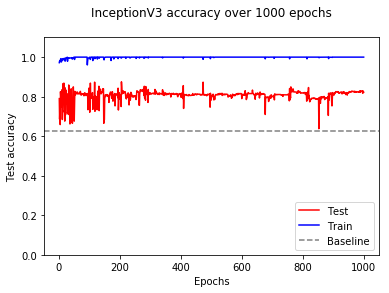

In [240]:
plot_accuracy('first_inception.txt','InceptionV3 accuracy over 1000 epochs\n')

             precision    recall  f1-score   support

          0       0.96      0.55      0.70       234
          1       0.79      0.98      0.87       390

avg / total       0.85      0.82      0.81       624



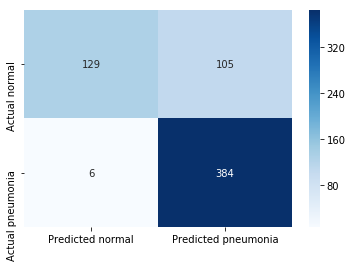

In [32]:
inc_pred_base = incmodel.predict(X_test)
inc_pred = [label_decoder(i) for i in inc_pred_base]
inc_cm = confusion_matrix(y_test, inc_pred)
sns.heatmap(inc_cm, annot=True,cmap='Blues',xticklabels = ['Predicted normal','Predicted pneumonia'],
           yticklabels=['Actual normal', 'Actual pneumonia'], fmt='d')
print(classification_report(y_test, inc_pred))

InceptionV3 yields very similar results to ResNet50 when trained on un-modified images.

What about if we standardise the images first with StandardScaler?

In [79]:
incmodel2 = keras.applications.InceptionV3(weights=None, classes=2, input_shape=(224,224,3))

In [80]:
incmodel2.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

In [83]:
incmodel2.fit(X_train_array, y_train_array_k,
          batch_size=8,
          epochs=10,
          verbose=1,
          validation_data=(X_test, y_test_k),
          callbacks=[history])

Train on 2682 samples, validate on 624 samples
Epoch 1/10
2682/2682 [==============================] - 85s 32ms/step - loss: 0.5104 - acc: 0.8367 - val_loss: 2.3805 - val_acc: 0.5849
Epoch 2/10
2682/2682 [==============================] - 52s 19ms/step - loss: 0.2522 - acc: 0.9053 - val_loss: 4.5370 - val_acc: 0.4119
Epoch 3/10
2682/2682 [==============================] - 52s 19ms/step - loss: 0.1599 - acc: 0.9433 - val_loss: 2.3138 - val_acc: 0.5449
Epoch 4/10
2682/2682 [==============================] - 52s 20ms/step - loss: 0.1630 - acc: 0.9471 - val_loss: 2.0750 - val_acc: 0.6522
Epoch 5/10
2682/2682 [==============================] - 53s 20ms/step - loss: 0.1476 - acc: 0.9441 - val_loss: 4.4335 - val_acc: 0.4744
Epoch 6/10
2682/2682 [==============================] - 52s 19ms/step - loss: 0.1255 - acc: 0.9489 - val_loss: 0.9174 - val_acc: 0.7019
Epoch 7/10
2682/2682 [==============================] - 51s 19ms/step - loss: 0.1338 - acc: 0.9497 - val_loss: 0.7906 - val_acc: 0.7388
E

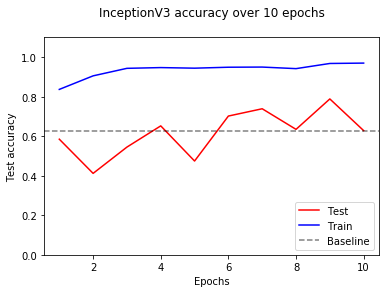

In [241]:
plot_accuracy('std_inception.txt','InceptionV3 accuracy over 10 epochs\n')

Much like ResNet50, standardising the pixel values of the images led to a reduction in accuracy, although this was performed only over 10 epochs, simply because it didn't look like it was going to be worthwhile running it longer. It's possible that this loss of accuracy reflects an error in the application of StandardScaler, however moving forward I'll be either leaving images un-modified or rescaled using keras' built-in image preprocessing functions.

---------------------------------
## <a id='6'>6. Modelling with augmentation</a>

Improving the number and variety of images available for training the CNN is one way of improving classification accuracy. Since I am not in a position to easily collect more chest X-ray images, I can use augmentation to generate more varied images based on the images already available. This is achieved by applying random transformations to the images such as reflections, translations, rotations and shearing. In addition to generating more data from an existing dataset, this technique can help address over-fitting to the training set by helping the CNN to more effectively identify the salient features of an image by altering the context in which these features appear.

### <a id='6.1'>6.1 Generating augmented image sets</a>

Keras can perform image augmentation through the use of ImageDataGenerator objects. These allow you to define various transformations and other parameters to apply to each image as it is fed into the model. To begin with, I have elected to only apply horizontal reflections, x/y shifts and pixel rescaling (to adjust pixel values to a range between 0-1). Since the test images are all oriented the same way vertically, I decided not to apply vertical reflection or rotations to the images.

In [52]:
#Define image generator with augmentation steps
aug = keras.preprocessing.image.ImageDataGenerator(horizontal_flip=True, 
                                                   width_shift_range=0.2, 
                                                   height_shift_range=0.2,
                                                   rescale=1./255)
testaug = keras.preprocessing.image.ImageDataGenerator(
                                                   rescale=1./255)
valaug = keras.preprocessing.image.ImageDataGenerator(
                                                   rescale=1./255)

In [53]:
y_train = keras.utils.to_categorical(np.array(train_labels_usample))
y_test = keras.utils.to_categorical(np.array(test_labels))

When generating the augmented image data, it is important to include shuffle=False in order to preserve the relationship between images and class labels.

In [54]:
train_aug = aug.flow(np.array(X_train_array), batch_size=24, shuffle=False)

In [55]:
test_aug = testaug.flow(np.array(X_test), batch_size=24, shuffle=False)

In [56]:
val_aug = valaug.flow(np.array(val_images), batch_size=24, shuffle=False)

### <a id='6.2'>6.2 ResNet50 modelling using augmented images</a>

In [27]:
model = keras.applications.ResNet50(include_top=True, weights=None, classes=2)

In [28]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

Augmenting the images as they are fed into the network adds computation time to each epoch, so I am running this model for 500 epochs instead of 1000.

In [33]:
model.fit_generator(train_aug, steps_per_epoch=len(np.array(train_images)) / 24, epochs=500, 
                    validation_data=test_aug, callbacks=[history])

Epoch 1/500
218/217 [==============================] - 80s 366ms/step - loss: 0.1177 - acc: 0.9522 - val_loss: 1.1688 - val_acc: 0.7083
Epoch 2/500
218/217 [==============================] - 80s 366ms/step - loss: 0.1022 - acc: 0.9638 - val_loss: 0.9880 - val_acc: 0.7644
Epoch 3/500
218/217 [==============================] - 80s 366ms/step - loss: 0.0991 - acc: 0.9615 - val_loss: 0.7413 - val_acc: 0.7500
Epoch 4/500
218/217 [==============================] - 80s 366ms/step - loss: 0.1020 - acc: 0.9648 - val_loss: 0.5168 - val_acc: 0.8125
Epoch 5/500
218/217 [==============================] - 80s 365ms/step - loss: 0.0936 - acc: 0.9627 - val_loss: 1.0816 - val_acc: 0.7580
Epoch 6/500
218/217 [==============================] - 80s 368ms/step - loss: 0.0828 - acc: 0.9688 - val_loss: 1.8436 - val_acc: 0.6202
Epoch 7/500
218/217 [==============================] - 80s 366ms/step - loss: 0.0941 - acc: 0.9644 - val_loss: 1.7380 - val_acc: 0.6699
Epoch 8/500
218/217 [===========================

Epoch 61/500
218/217 [==============================] - 79s 364ms/step - loss: 0.0252 - acc: 0.9901 - val_loss: 3.4178 - val_acc: 0.6490
Epoch 62/500
218/217 [==============================] - 80s 365ms/step - loss: 0.0126 - acc: 0.9956 - val_loss: 4.3809 - val_acc: 0.6426
Epoch 63/500
218/217 [==============================] - 79s 364ms/step - loss: 0.0124 - acc: 0.9957 - val_loss: 1.1311 - val_acc: 0.7163
Epoch 64/500
218/217 [==============================] - 79s 364ms/step - loss: 0.0290 - acc: 0.9895 - val_loss: 1.7143 - val_acc: 0.6955
Epoch 65/500
218/217 [==============================] - 79s 364ms/step - loss: 0.0093 - acc: 0.9971 - val_loss: 3.2179 - val_acc: 0.6635
Epoch 66/500
218/217 [==============================] - 79s 364ms/step - loss: 0.0200 - acc: 0.9937 - val_loss: 2.3764 - val_acc: 0.5577
Epoch 67/500
218/217 [==============================] - 79s 364ms/step - loss: 0.0137 - acc: 0.9952 - val_loss: 2.4014 - val_acc: 0.6651
Epoch 68/500
218/217 [===================

218/217 [==============================] - 79s 364ms/step - loss: 0.0058 - acc: 0.9978 - val_loss: 4.2558 - val_acc: 0.6715
Epoch 180/500
218/217 [==============================] - 80s 365ms/step - loss: 0.0044 - acc: 0.9987 - val_loss: 4.3204 - val_acc: 0.6538
Epoch 181/500
218/217 [==============================] - 79s 365ms/step - loss: 0.0040 - acc: 0.9987 - val_loss: 2.9662 - val_acc: 0.7131
Epoch 182/500
218/217 [==============================] - 79s 365ms/step - loss: 0.0039 - acc: 0.9987 - val_loss: 2.8569 - val_acc: 0.6875
Epoch 183/500
218/217 [==============================] - 80s 366ms/step - loss: 0.0094 - acc: 0.9973 - val_loss: 2.3250 - val_acc: 0.7244
Epoch 184/500
218/217 [==============================] - 79s 364ms/step - loss: 0.0061 - acc: 0.9990 - val_loss: 3.7359 - val_acc: 0.6651
Epoch 185/500
218/217 [==============================] - 80s 365ms/step - loss: 0.0043 - acc: 0.9981 - val_loss: 3.3469 - val_acc: 0.6811
Epoch 186/500
218/217 [=========================

Epoch 297/500
218/217 [==============================] - 79s 365ms/step - loss: 0.0234 - acc: 0.9935 - val_loss: 4.4021 - val_acc: 0.6522
Epoch 298/500
218/217 [==============================] - 80s 365ms/step - loss: 0.0027 - acc: 0.9992 - val_loss: 3.6797 - val_acc: 0.6619
Epoch 299/500
218/217 [==============================] - 79s 364ms/step - loss: 8.5279e-04 - acc: 0.9998 - val_loss: 3.6594 - val_acc: 0.6747
Epoch 300/500
218/217 [==============================] - 79s 364ms/step - loss: 0.0015 - acc: 0.9992 - val_loss: 2.9613 - val_acc: 0.7003
Epoch 301/500
218/217 [==============================] - 79s 364ms/step - loss: 3.6254e-04 - acc: 1.0000 - val_loss: 3.4765 - val_acc: 0.6795
Epoch 302/500
218/217 [==============================] - 79s 364ms/step - loss: 4.1346e-04 - acc: 1.0000 - val_loss: 3.5819 - val_acc: 0.6763
Epoch 303/500
218/217 [==============================] - 79s 364ms/step - loss: 2.1957e-04 - acc: 1.0000 - val_loss: 3.8309 - val_acc: 0.6619
Epoch 304/500
218/

218/217 [==============================] - 80s 365ms/step - loss: 4.2076e-04 - acc: 0.9998 - val_loss: 3.5786 - val_acc: 0.6875
Epoch 414/500
218/217 [==============================] - 79s 364ms/step - loss: 0.0040 - acc: 0.9990 - val_loss: 3.3423 - val_acc: 0.7003
Epoch 415/500
218/217 [==============================] - 79s 364ms/step - loss: 0.0021 - acc: 0.9990 - val_loss: 4.2544 - val_acc: 0.6635
Epoch 416/500
218/217 [==============================] - 79s 364ms/step - loss: 5.0691e-04 - acc: 1.0000 - val_loss: 3.9801 - val_acc: 0.6667
Epoch 417/500
218/217 [==============================] - 79s 364ms/step - loss: 1.9388e-04 - acc: 1.0000 - val_loss: 3.8915 - val_acc: 0.6651
Epoch 418/500
218/217 [==============================] - 79s 364ms/step - loss: 3.1398e-04 - acc: 1.0000 - val_loss: 4.1665 - val_acc: 0.6747
Epoch 419/500
218/217 [==============================] - 79s 364ms/step - loss: 1.3448e-04 - acc: 1.0000 - val_loss: 4.4731 - val_acc: 0.6603
Epoch 420/500
218/217 [=====

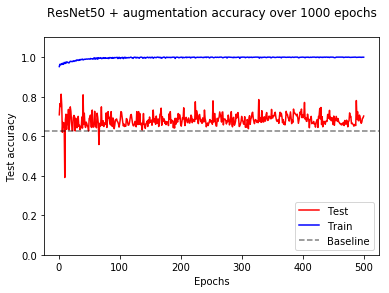

In [242]:
plot_accuracy('res_augmented.txt','ResNet50 + augmentation accuracy over 1000 epochs\n')

In [42]:
#Saving using save_model was taking too long, so I'm saving weights and model architecture separately
model.save_weights('res_aug_500.h5')
model_json = model.to_json()
with open('res_aug_500.json', "w") as json_file:
    json_file.write(model_json)
json_file.close()

             precision    recall  f1-score   support

          0       1.00      0.22      0.36       234
          1       0.68      1.00      0.81       390

avg / total       0.80      0.71      0.64       624



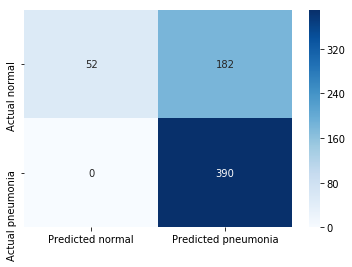

In [41]:
resaug_pred_base = model.predict(X_test)
resaug_pred = [label_decoder(i) for i in resaug_pred_base]
resaug_cm = confusion_matrix(np.array(test_labels), resaug_pred)
sns.heatmap(resaug_cm, annot=True,cmap='Blues',xticklabels = ['Predicted normal','Predicted pneumonia'],
           yticklabels=['Actual normal', 'Actual pneumonia'], fmt='d')
print(classification_report(np.array(test_labels), resaug_pred))

Training a ResNet50 model from scratch using augmented data did not yield a higher accuracy or f1 score than the initial model using unmodified images.

As training a model from scratch with augmentation takes considerably longer than without, I did not have time to attempt this with InceptionV3 as well.

---------------------------------------------------------------------------
## <a id='7'>7. Transfer learning</a>

Instead of training the weights for each layer from scratch, we can use pre-trained weights. ResNet50, InceptionV3 and other CNN architectures have been trained extensively on the ImageNet collection of images for feature and object recognition. This means that with the pre-trained weights, these CNNs are likely to be more effective at extracting image features than a CNN trained from scratch. If I run my images through these networks without the final full-connected layers at the end, I have effectively performed a feature extraction step on them. I can then apply these feature-extracted arrays to my own fully-connected layers to carry out the classification. This technique is known as transfer learning.

### <a id='7.1'>7.1 ResNet50</a>

In [61]:
#Load pre-trained weights for resnet50 trained on ImageNet. Include_top = False means that the fully-connected layers at the end
#of the network are not included, and the output is an array of dimensions (1,1,2048)
#weight_path = 'resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'
base_resnet = keras.applications.ResNet50(include_top=False, weights='imagenet',input_shape=(224,224,3))

In [36]:
#Features are extracted by 'predicting' this 1,1,2048 matrix from the base images.
train_features = base_resnet.predict(X_train_array)
train_features_r = np.reshape(train_features, (-1, 1, 1, 2048)) #Included for safety but ended up being unnecessary

In [24]:
test_features = base_resnet.predict(X_test)
test_features = np.reshape(test_features, (-1, 1, 1, 2048))

In [41]:
#Double-checking the dimensions of the output of these models
test_features.shape

(624, 1, 1, 2048)

In [59]:
#Here we build the final fully-connected layers that will do the actual classification. Keeping things relatively simple here.
#Sigmoid activation was selected for the final layer as I have 2 classes
model = keras.models.Sequential()
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(256, activation='relu', input_dim=1*1*2048))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(2, activation='sigmoid'))

In [63]:
#Trying some new optimizer and loss variables
model.compile(optimizer=keras.optimizers.RMSprop(),
             loss='binary_crossentropy',
             metrics=['accuracy'])

In [65]:
model.fit(train_features,
         y_train_array_k,
         epochs=1000,
         batch_size=batch_size,
         validation_data=(test_features, y_test_k),
         callbacks=[history])

Train on 2682 samples, validate on 624 samples
Epoch 1/1000
2682/2682 [==============================] - 1s 279us/step - loss: 0.1190 - acc: 0.9582 - val_loss: 1.3671 - val_acc: 0.7155
Epoch 2/1000
2682/2682 [==============================] - 1s 279us/step - loss: 0.1333 - acc: 0.9551 - val_loss: 1.5644 - val_acc: 0.6771
Epoch 3/1000
2682/2682 [==============================] - 1s 276us/step - loss: 0.1131 - acc: 0.9592 - val_loss: 1.5553 - val_acc: 0.7155
Epoch 4/1000
2682/2682 [==============================] - 1s 287us/step - loss: 0.1193 - acc: 0.9581 - val_loss: 2.0014 - val_acc: 0.6619
Epoch 5/1000
2682/2682 [==============================] - 1s 298us/step - loss: 0.1083 - acc: 0.9622 - val_loss: 0.9959 - val_acc: 0.7772
Epoch 6/1000
2682/2682 [==============================] - 1s 288us/step - loss: 0.1176 - acc: 0.9562 - val_loss: 1.3946 - val_acc: 0.7212
Epoch 7/1000
2682/2682 [==============================] - 1s 301us/step - loss: 0.1134 - acc: 0.9625 - val_loss: 1.2576 - val

Epoch 118/1000
2682/2682 [==============================] - 1s 276us/step - loss: 0.0592 - acc: 0.9812 - val_loss: 2.9354 - val_acc: 0.7212
Epoch 119/1000
2682/2682 [==============================] - 1s 277us/step - loss: 0.0435 - acc: 0.9851 - val_loss: 3.0789 - val_acc: 0.7131
Epoch 120/1000
2682/2682 [==============================] - 1s 275us/step - loss: 0.0452 - acc: 0.9851 - val_loss: 2.3150 - val_acc: 0.7596
Epoch 121/1000
2682/2682 [==============================] - 1s 279us/step - loss: 0.0415 - acc: 0.9866 - val_loss: 3.1616 - val_acc: 0.7051
Epoch 122/1000
2682/2682 [==============================] - 1s 276us/step - loss: 0.0552 - acc: 0.9827 - val_loss: 2.6331 - val_acc: 0.7388
Epoch 123/1000
2682/2682 [==============================] - 1s 275us/step - loss: 0.0515 - acc: 0.9847 - val_loss: 3.1513 - val_acc: 0.7099
Epoch 124/1000
2682/2682 [==============================] - 1s 276us/step - loss: 0.0439 - acc: 0.9840 - val_loss: 2.9922 - val_acc: 0.7212
Epoch 125/1000
2682/

2682/2682 [==============================] - 1s 275us/step - loss: 0.0339 - acc: 0.9892 - val_loss: 3.6444 - val_acc: 0.7035
Epoch 235/1000
2682/2682 [==============================] - 1s 278us/step - loss: 0.0311 - acc: 0.9916 - val_loss: 3.4399 - val_acc: 0.7276
Epoch 236/1000
2682/2682 [==============================] - 1s 276us/step - loss: 0.0306 - acc: 0.9914 - val_loss: 3.9696 - val_acc: 0.6875
Epoch 237/1000
2682/2682 [==============================] - 1s 275us/step - loss: 0.0291 - acc: 0.9907 - val_loss: 2.5321 - val_acc: 0.7788
Epoch 238/1000
2682/2682 [==============================] - 1s 276us/step - loss: 0.0283 - acc: 0.9918 - val_loss: 3.1147 - val_acc: 0.7436
Epoch 239/1000
2682/2682 [==============================] - 1s 275us/step - loss: 0.0206 - acc: 0.9937 - val_loss: 3.3799 - val_acc: 0.7276
Epoch 240/1000
2682/2682 [==============================] - 1s 285us/step - loss: 0.0342 - acc: 0.9899 - val_loss: 3.3678 - val_acc: 0.7276
Epoch 241/1000
2682/2682 [=========

2682/2682 [==============================] - 1s 286us/step - loss: 0.0312 - acc: 0.9922 - val_loss: 3.4384 - val_acc: 0.7356
Epoch 351/1000
2682/2682 [==============================] - 1s 282us/step - loss: 0.0148 - acc: 0.9974 - val_loss: 3.6491 - val_acc: 0.7163
Epoch 352/1000
2682/2682 [==============================] - 1s 276us/step - loss: 0.0125 - acc: 0.9948 - val_loss: 4.1341 - val_acc: 0.6875
Epoch 353/1000
2682/2682 [==============================] - 1s 276us/step - loss: 0.0143 - acc: 0.9955 - val_loss: 2.9574 - val_acc: 0.7500
Epoch 354/1000
2682/2682 [==============================] - 1s 276us/step - loss: 0.0211 - acc: 0.9959 - val_loss: 4.0095 - val_acc: 0.7035
Epoch 355/1000
2682/2682 [==============================] - 1s 277us/step - loss: 0.0213 - acc: 0.9955 - val_loss: 3.4070 - val_acc: 0.7420
Epoch 356/1000
2682/2682 [==============================] - 1s 293us/step - loss: 0.0121 - acc: 0.9963 - val_loss: 3.5279 - val_acc: 0.7356
Epoch 357/1000
2682/2682 [=========

2682/2682 [==============================] - 1s 279us/step - loss: 0.0190 - acc: 0.9970 - val_loss: 3.7554 - val_acc: 0.7244
Epoch 467/1000
2682/2682 [==============================] - 1s 276us/step - loss: 0.0126 - acc: 0.9978 - val_loss: 4.1920 - val_acc: 0.6971
Epoch 468/1000
2682/2682 [==============================] - 1s 277us/step - loss: 0.0154 - acc: 0.9963 - val_loss: 3.5873 - val_acc: 0.7372
Epoch 469/1000
2682/2682 [==============================] - 1s 284us/step - loss: 0.0215 - acc: 0.9944 - val_loss: 4.1891 - val_acc: 0.6939
Epoch 470/1000
2682/2682 [==============================] - 1s 279us/step - loss: 0.0103 - acc: 0.9966 - val_loss: 3.5730 - val_acc: 0.7372
Epoch 471/1000
2682/2682 [==============================] - 1s 275us/step - loss: 0.0128 - acc: 0.9955 - val_loss: 3.7227 - val_acc: 0.7212
Epoch 472/1000
2682/2682 [==============================] - 1s 276us/step - loss: 0.0083 - acc: 0.9963 - val_loss: 4.1601 - val_acc: 0.6987
Epoch 473/1000
2682/2682 [=========

2682/2682 [==============================] - 1s 265us/step - loss: 0.0105 - acc: 0.9974 - val_loss: 3.3732 - val_acc: 0.7452
Epoch 583/1000
2682/2682 [==============================] - 1s 263us/step - loss: 0.0107 - acc: 0.9978 - val_loss: 3.8509 - val_acc: 0.7228
Epoch 584/1000
2682/2682 [==============================] - 1s 264us/step - loss: 0.0188 - acc: 0.9952 - val_loss: 3.5959 - val_acc: 0.7308
Epoch 585/1000
2682/2682 [==============================] - 1s 264us/step - loss: 0.0104 - acc: 0.9974 - val_loss: 3.5159 - val_acc: 0.7420
Epoch 586/1000
2682/2682 [==============================] - 1s 270us/step - loss: 0.0095 - acc: 0.9974 - val_loss: 4.1503 - val_acc: 0.7019
Epoch 587/1000
2682/2682 [==============================] - 1s 264us/step - loss: 0.0139 - acc: 0.9978 - val_loss: 3.9715 - val_acc: 0.7131
Epoch 588/1000
2682/2682 [==============================] - 1s 263us/step - loss: 0.0133 - acc: 0.9966 - val_loss: 4.0741 - val_acc: 0.7003
Epoch 589/1000
2682/2682 [=========

2682/2682 [==============================] - 1s 265us/step - loss: 0.0058 - acc: 0.9981 - val_loss: 4.2350 - val_acc: 0.7051
Epoch 699/1000
2682/2682 [==============================] - 1s 263us/step - loss: 0.0121 - acc: 0.9974 - val_loss: 4.1983 - val_acc: 0.7035
Epoch 700/1000
2682/2682 [==============================] - 1s 263us/step - loss: 0.0065 - acc: 0.9989 - val_loss: 4.1058 - val_acc: 0.7051
Epoch 701/1000
2682/2682 [==============================] - 1s 265us/step - loss: 0.0036 - acc: 0.9978 - val_loss: 4.5693 - val_acc: 0.6907
Epoch 702/1000
2682/2682 [==============================] - 1s 262us/step - loss: 0.0058 - acc: 0.9987 - val_loss: 3.9426 - val_acc: 0.7244
Epoch 703/1000
2682/2682 [==============================] - 1s 263us/step - loss: 0.0052 - acc: 0.9985 - val_loss: 4.0954 - val_acc: 0.7115
Epoch 704/1000
2682/2682 [==============================] - 1s 264us/step - loss: 0.0094 - acc: 0.9981 - val_loss: 4.6621 - val_acc: 0.6779
Epoch 705/1000
2682/2682 [=========

2682/2682 [==============================] - 1s 281us/step - loss: 0.0038 - acc: 0.9989 - val_loss: 4.0138 - val_acc: 0.7163
Epoch 815/1000
2682/2682 [==============================] - 1s 276us/step - loss: 0.0052 - acc: 0.9981 - val_loss: 4.1217 - val_acc: 0.7099
Epoch 816/1000
2682/2682 [==============================] - 1s 279us/step - loss: 0.0044 - acc: 0.9981 - val_loss: 3.8743 - val_acc: 0.7372
Epoch 817/1000
2682/2682 [==============================] - 1s 279us/step - loss: 0.0011 - acc: 0.9996 - val_loss: 3.8075 - val_acc: 0.7404
Epoch 818/1000
2682/2682 [==============================] - 1s 275us/step - loss: 0.0076 - acc: 0.9981 - val_loss: 4.5698 - val_acc: 0.6859
Epoch 819/1000
2682/2682 [==============================] - 1s 282us/step - loss: 0.0076 - acc: 0.9978 - val_loss: 3.8038 - val_acc: 0.7324
Epoch 820/1000
2682/2682 [==============================] - 1s 280us/step - loss: 0.0034 - acc: 0.9993 - val_loss: 3.9867 - val_acc: 0.7196
Epoch 821/1000
2682/2682 [=========

2682/2682 [==============================] - 1s 273us/step - loss: 0.0072 - acc: 0.9978 - val_loss: 4.1184 - val_acc: 0.7067
Epoch 931/1000
2682/2682 [==============================] - 1s 270us/step - loss: 0.0023 - acc: 0.9989 - val_loss: 4.1161 - val_acc: 0.7147
Epoch 932/1000
2682/2682 [==============================] - 1s 276us/step - loss: 0.0058 - acc: 0.9978 - val_loss: 3.7433 - val_acc: 0.7420
Epoch 933/1000
2682/2682 [==============================] - 1s 272us/step - loss: 0.0106 - acc: 0.9978 - val_loss: 3.8545 - val_acc: 0.7356
Epoch 934/1000
2682/2682 [==============================] - 1s 276us/step - loss: 0.0045 - acc: 0.9993 - val_loss: 4.5892 - val_acc: 0.6763
Epoch 935/1000
2682/2682 [==============================] - 1s 272us/step - loss: 0.0043 - acc: 0.9989 - val_loss: 4.0441 - val_acc: 0.7163
Epoch 936/1000
2682/2682 [==============================] - 1s 271us/step - loss: 0.0052 - acc: 0.9978 - val_loss: 3.8648 - val_acc: 0.7324
Epoch 937/1000
2682/2682 [=========

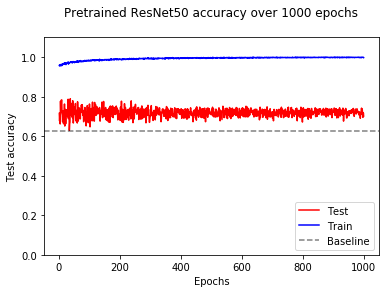

In [243]:
plot_accuracy('pretrained_res.txt','Pretrained ResNet50 accuracy over 1000 epochs\n')

             precision    recall  f1-score   support

          0       0.93      0.22      0.36       234
          1       0.68      0.99      0.81       390

avg / total       0.77      0.70      0.64       624



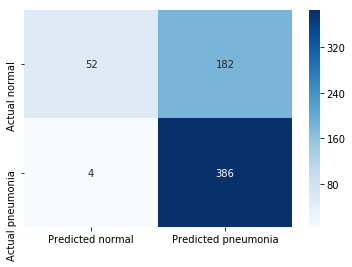

In [66]:
model_base = model.predict(test_features)
model_pred = [label_decoder(i) for i in model_base]
cm = confusion_matrix(y_test, model_pred)
sns.heatmap(cm, annot=True,cmap='Blues',xticklabels = ['Predicted normal','Predicted pneumonia'],
           yticklabels=['Actual normal', 'Actual pneumonia'], fmt='d')
print(classification_report(y_test, model_pred))

Again, this model is performing better than baseline, but a bit worse than training on unmodified images from scratch.

### <a id='7.2'>7.2 InceptionV3</a>

I will try the same thing using InceptionV3 for feature extraction.

In [25]:
#weight_path = 'inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
base_inc = keras.applications.InceptionV3(include_top=False, weights='imagenet', input_shape = (224,224,3))

In [161]:
inc_X_train = base_inc.predict(X_train_array)
inc_X_test = base_inc.predict(X_test)

In [162]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(256, activation='relu', input_dim=5*5*2048))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(2, activation='sigmoid'))

In [163]:
model.compile(optimizer=keras.optimizers.RMSprop(),
             loss='binary_crossentropy',
             metrics=['accuracy'])

In [164]:
model.fit(inc_X_train,
         y_train_array_k,
         epochs=1000,
         batch_size=batch_size,
         validation_data=(inc_X_test, y_test_k),
         callbacks=[history])

Train on 2682 samples, validate on 624 samples
Epoch 1/1000
2682/2682 [==============================] - 5s 2ms/step - loss: 4.9249 - acc: 0.6775 - val_loss: 4.8874 - val_acc: 0.6819
Epoch 2/1000
2682/2682 [==============================] - 3s 982us/step - loss: 2.8788 - acc: 0.8134 - val_loss: 4.3084 - val_acc: 0.7163
Epoch 3/1000
2682/2682 [==============================] - 3s 982us/step - loss: 2.4888 - acc: 0.8389 - val_loss: 5.5148 - val_acc: 0.6522
Epoch 4/1000
2682/2682 [==============================] - 3s 980us/step - loss: 1.9072 - acc: 0.8753 - val_loss: 4.1607 - val_acc: 0.7284
Epoch 5/1000
2682/2682 [==============================] - 3s 982us/step - loss: 1.6851 - acc: 0.8887 - val_loss: 5.6775 - val_acc: 0.6434
Epoch 6/1000
2682/2682 [==============================] - 3s 979us/step - loss: 1.7431 - acc: 0.8859 - val_loss: 4.5757 - val_acc: 0.7043
Epoch 7/1000
2682/2682 [==============================] - 3s 982us/step - loss: 1.4620 - acc: 0.9049 - val_loss: 4.0135 - val_a

Epoch 60/1000
2682/2682 [==============================] - 3s 977us/step - loss: 0.4437 - acc: 0.9705 - val_loss: 3.7198 - val_acc: 0.7588
Epoch 61/1000
2682/2682 [==============================] - 3s 979us/step - loss: 0.4636 - acc: 0.9704 - val_loss: 4.8741 - val_acc: 0.6907
Epoch 62/1000
2682/2682 [==============================] - 3s 980us/step - loss: 0.4309 - acc: 0.9713 - val_loss: 3.8020 - val_acc: 0.7580
Epoch 63/1000
2682/2682 [==============================] - 3s 980us/step - loss: 0.4632 - acc: 0.9692 - val_loss: 4.9667 - val_acc: 0.6859
Epoch 64/1000
2682/2682 [==============================] - 3s 981us/step - loss: 0.4187 - acc: 0.9724 - val_loss: 3.9943 - val_acc: 0.7404
Epoch 65/1000
2682/2682 [==============================] - 3s 983us/step - loss: 0.4275 - acc: 0.9713 - val_loss: 4.9409 - val_acc: 0.6867
Epoch 66/1000
2682/2682 [==============================] - 3s 980us/step - loss: 0.3803 - acc: 0.9739 - val_loss: 4.2103 - val_acc: 0.7284
Epoch 67/1000
2682/2682 [==

Epoch 119/1000
2682/2682 [==============================] - 3s 984us/step - loss: 0.2119 - acc: 0.9856 - val_loss: 4.9202 - val_acc: 0.6907
Epoch 120/1000
2682/2682 [==============================] - 3s 984us/step - loss: 0.2349 - acc: 0.9845 - val_loss: 4.5189 - val_acc: 0.7147
Epoch 121/1000
2682/2682 [==============================] - 3s 986us/step - loss: 0.1875 - acc: 0.9871 - val_loss: 4.4569 - val_acc: 0.7155
Epoch 122/1000
2682/2682 [==============================] - 3s 978us/step - loss: 0.2422 - acc: 0.9840 - val_loss: 4.5407 - val_acc: 0.7099
Epoch 123/1000
2682/2682 [==============================] - 3s 980us/step - loss: 0.2159 - acc: 0.9860 - val_loss: 4.9699 - val_acc: 0.6851
Epoch 124/1000
2682/2682 [==============================] - 3s 978us/step - loss: 0.2291 - acc: 0.9849 - val_loss: 4.4982 - val_acc: 0.7131
Epoch 125/1000
2682/2682 [==============================] - 3s 984us/step - loss: 0.2359 - acc: 0.9843 - val_loss: 4.9313 - val_acc: 0.6891
Epoch 126/1000
2682/

2682/2682 [==============================] - 3s 980us/step - loss: 0.0976 - acc: 0.9937 - val_loss: 5.5623 - val_acc: 0.6506
Epoch 236/1000
2682/2682 [==============================] - 3s 978us/step - loss: 0.1136 - acc: 0.9929 - val_loss: 4.9121 - val_acc: 0.6875
Epoch 237/1000
2682/2682 [==============================] - 3s 985us/step - loss: 0.0877 - acc: 0.9940 - val_loss: 5.4131 - val_acc: 0.6619
Epoch 238/1000
2682/2682 [==============================] - 3s 978us/step - loss: 0.1330 - acc: 0.9909 - val_loss: 5.0649 - val_acc: 0.6811
Epoch 239/1000
2682/2682 [==============================] - 3s 979us/step - loss: 0.1164 - acc: 0.9924 - val_loss: 5.0095 - val_acc: 0.6875
Epoch 240/1000
2682/2682 [==============================] - 3s 980us/step - loss: 0.0868 - acc: 0.9940 - val_loss: 4.9193 - val_acc: 0.6891
Epoch 241/1000
2682/2682 [==============================] - 3s 988us/step - loss: 0.0795 - acc: 0.9948 - val_loss: 5.6872 - val_acc: 0.6442
Epoch 242/1000
2682/2682 [=========

Epoch 352/1000
2682/2682 [==============================] - 3s 981us/step - loss: 0.0299 - acc: 0.9981 - val_loss: 5.0416 - val_acc: 0.6811
Epoch 353/1000
2682/2682 [==============================] - 3s 983us/step - loss: 0.0300 - acc: 0.9981 - val_loss: 4.7425 - val_acc: 0.6955
Epoch 354/1000
2682/2682 [==============================] - 3s 986us/step - loss: 0.0299 - acc: 0.9981 - val_loss: 4.8738 - val_acc: 0.6867
Epoch 355/1000
2682/2682 [==============================] - 3s 982us/step - loss: 0.0307 - acc: 0.9979 - val_loss: 5.1743 - val_acc: 0.6747
Epoch 356/1000
2682/2682 [==============================] - 3s 977us/step - loss: 0.0333 - acc: 0.9978 - val_loss: 4.7519 - val_acc: 0.6955
Epoch 357/1000
2682/2682 [==============================] - 3s 980us/step - loss: 0.0386 - acc: 0.9972 - val_loss: 5.0736 - val_acc: 0.6779
Epoch 358/1000
2682/2682 [==============================] - 3s 980us/step - loss: 0.0299 - acc: 0.9981 - val_loss: 5.1111 - val_acc: 0.6779
Epoch 359/1000
2682/

2682/2682 [==============================] - 3s 986us/step - loss: 0.0299 - acc: 0.9981 - val_loss: 5.0057 - val_acc: 0.6803
Epoch 469/1000
2682/2682 [==============================] - 3s 983us/step - loss: 0.0301 - acc: 0.9979 - val_loss: 5.1309 - val_acc: 0.6763
Epoch 470/1000
2682/2682 [==============================] - 3s 983us/step - loss: 0.0322 - acc: 0.9978 - val_loss: 5.0998 - val_acc: 0.6795
Epoch 471/1000
2682/2682 [==============================] - 3s 988us/step - loss: 0.0299 - acc: 0.9981 - val_loss: 5.0998 - val_acc: 0.6795
Epoch 472/1000
2682/2682 [==============================] - 3s 983us/step - loss: 0.0299 - acc: 0.9981 - val_loss: 5.0998 - val_acc: 0.6795
Epoch 473/1000
2682/2682 [==============================] - 3s 985us/step - loss: 0.0303 - acc: 0.9979 - val_loss: 4.8039 - val_acc: 0.6947
Epoch 474/1000
2682/2682 [==============================] - 3s 982us/step - loss: 0.0300 - acc: 0.9981 - val_loss: 4.8695 - val_acc: 0.6891
Epoch 475/1000
2682/2682 [=========

2682/2682 [==============================] - 3s 996us/step - loss: 0.0350 - acc: 0.9978 - val_loss: 4.8640 - val_acc: 0.6923
Epoch 585/1000
2682/2682 [==============================] - 3s 1ms/step - loss: 0.0344 - acc: 0.9978 - val_loss: 5.1920 - val_acc: 0.6731
Epoch 586/1000
2682/2682 [==============================] - 3s 1ms/step - loss: 0.0299 - acc: 0.9981 - val_loss: 5.1920 - val_acc: 0.6731
Epoch 587/1000
2682/2682 [==============================] - 3s 994us/step - loss: 0.0299 - acc: 0.9981 - val_loss: 5.1806 - val_acc: 0.6739
Epoch 588/1000
2682/2682 [==============================] - 3s 1ms/step - loss: 0.0359 - acc: 0.9978 - val_loss: 5.2540 - val_acc: 0.6699
Epoch 589/1000
2682/2682 [==============================] - 3s 993us/step - loss: 0.0299 - acc: 0.9981 - val_loss: 5.4016 - val_acc: 0.6619
Epoch 590/1000
2682/2682 [==============================] - 3s 991us/step - loss: 0.0343 - acc: 0.9974 - val_loss: 4.6874 - val_acc: 0.6987
Epoch 591/1000
2682/2682 [===============

Epoch 643/1000
2682/2682 [==============================] - 3s 991us/step - loss: 0.0356 - acc: 0.9978 - val_loss: 5.0926 - val_acc: 0.6787
Epoch 644/1000
2682/2682 [==============================] - 3s 986us/step - loss: 0.0299 - acc: 0.9981 - val_loss: 5.0926 - val_acc: 0.6787
Epoch 645/1000
2682/2682 [==============================] - 3s 988us/step - loss: 0.0299 - acc: 0.9981 - val_loss: 5.0276 - val_acc: 0.6827
Epoch 646/1000
2682/2682 [==============================] - 3s 994us/step - loss: 0.0299 - acc: 0.9981 - val_loss: 5.0276 - val_acc: 0.6827
Epoch 647/1000
2682/2682 [==============================] - 3s 991us/step - loss: 0.0299 - acc: 0.9981 - val_loss: 5.0276 - val_acc: 0.6827
Epoch 648/1000
2682/2682 [==============================] - 3s 989us/step - loss: 0.0299 - acc: 0.9981 - val_loss: 5.0276 - val_acc: 0.6827
Epoch 649/1000
2682/2682 [==============================] - 3s 985us/step - loss: 0.0304 - acc: 0.9979 - val_loss: 4.7995 - val_acc: 0.6939
Epoch 650/1000
2682/

2682/2682 [==============================] - 3s 976us/step - loss: 0.0299 - acc: 0.9981 - val_loss: 5.2542 - val_acc: 0.6683
Epoch 760/1000
2682/2682 [==============================] - 3s 974us/step - loss: 0.0299 - acc: 0.9981 - val_loss: 5.1023 - val_acc: 0.6763
Epoch 761/1000
2682/2682 [==============================] - 3s 976us/step - loss: 0.0299 - acc: 0.9981 - val_loss: 5.0917 - val_acc: 0.6779
Epoch 762/1000
2682/2682 [==============================] - 3s 979us/step - loss: 0.0299 - acc: 0.9981 - val_loss: 5.2744 - val_acc: 0.6683
Epoch 763/1000
2682/2682 [==============================] - 3s 978us/step - loss: 0.0299 - acc: 0.9981 - val_loss: 5.2744 - val_acc: 0.6683
Epoch 764/1000
2682/2682 [==============================] - 3s 976us/step - loss: 0.0300 - acc: 0.9979 - val_loss: 5.1879 - val_acc: 0.6731
Epoch 765/1000
2682/2682 [==============================] - 3s 978us/step - loss: 0.0299 - acc: 0.9981 - val_loss: 5.1879 - val_acc: 0.6731
Epoch 766/1000
2682/2682 [=========

2682/2682 [==============================] - 3s 991us/step - loss: 0.0327 - acc: 0.9978 - val_loss: 4.9997 - val_acc: 0.6843
Epoch 876/1000
2682/2682 [==============================] - 3s 986us/step - loss: 0.0299 - acc: 0.9981 - val_loss: 4.9997 - val_acc: 0.6843
Epoch 877/1000
2682/2682 [==============================] - 3s 985us/step - loss: 0.0299 - acc: 0.9981 - val_loss: 5.0503 - val_acc: 0.6827
Epoch 878/1000
2682/2682 [==============================] - 3s 980us/step - loss: 0.0299 - acc: 0.9981 - val_loss: 5.0503 - val_acc: 0.6827
Epoch 879/1000
2682/2682 [==============================] - 3s 989us/step - loss: 0.0299 - acc: 0.9981 - val_loss: 5.0503 - val_acc: 0.6827
Epoch 880/1000
2682/2682 [==============================] - 3s 990us/step - loss: 0.0299 - acc: 0.9981 - val_loss: 5.0503 - val_acc: 0.6827
Epoch 881/1000
2682/2682 [==============================] - 3s 998us/step - loss: 0.0299 - acc: 0.9981 - val_loss: 5.0503 - val_acc: 0.6827
Epoch 882/1000
2682/2682 [=========

2682/2682 [==============================] - 3s 973us/step - loss: 0.0299 - acc: 0.9981 - val_loss: 4.9082 - val_acc: 0.6859
Epoch 992/1000
2682/2682 [==============================] - 3s 978us/step - loss: 0.0299 - acc: 0.9981 - val_loss: 4.9082 - val_acc: 0.6859
Epoch 993/1000
2682/2682 [==============================] - 3s 977us/step - loss: 0.0299 - acc: 0.9981 - val_loss: 5.1658 - val_acc: 0.6763
Epoch 994/1000
2682/2682 [==============================] - 3s 980us/step - loss: 0.0299 - acc: 0.9981 - val_loss: 5.1658 - val_acc: 0.6763
Epoch 995/1000
2682/2682 [==============================] - 3s 984us/step - loss: 0.0299 - acc: 0.9981 - val_loss: 5.1658 - val_acc: 0.6763
Epoch 996/1000
2682/2682 [==============================] - 3s 976us/step - loss: 0.0299 - acc: 0.9981 - val_loss: 5.1658 - val_acc: 0.6763
Epoch 997/1000
2682/2682 [==============================] - 3s 977us/step - loss: 0.0299 - acc: 0.9981 - val_loss: 5.1658 - val_acc: 0.6763
Epoch 998/1000
2682/2682 [=========

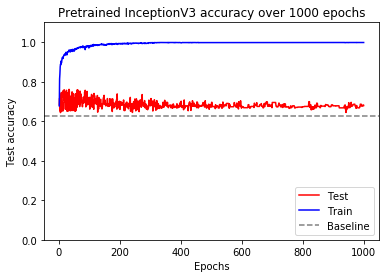

In [244]:
plot_accuracy('pretrained_inc.txt', 'Pretrained InceptionV3 accuracy over 1000 epochs')

             precision    recall  f1-score   support

          0       0.97      0.15      0.26       234
          1       0.66      1.00      0.80       390

avg / total       0.78      0.68      0.59       624



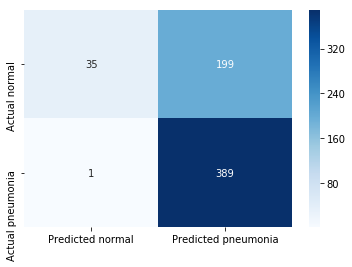

In [166]:
model_base = model.predict(inc_X_test)
model_pred = [label_decoder(i) for i in model_base]
cm = confusion_matrix(y_test, model_pred)
sns.heatmap(cm, annot=True,cmap='Blues',xticklabels = ['Predicted normal','Predicted pneumonia'],
           yticklabels=['Actual normal', 'Actual pneumonia'], fmt='d')
print(classification_report(y_test, model_pred))

As with ResNet50, using InceptionV3 for feature extraction is slightly worse than training the base model from scratch with unmodified images.

---------------------------------------------------------------
## <a id='8'>8. Transfer learning with augmentation</a>

Finally, I will attempt to combine these two approaches and use ResNet50/InceptionV3 to extract features from augmented image sets before classification with my own fully-connected layers.

### <a id='8.1'>8.1 ResNet50</a>

In [62]:
#Generate features from augmented images using ResNet. Augmented DataGenerators are the same ones defined above.
resX_train_aug = base_resnet.predict_generator(train_aug,steps = len(np.array(train_images_usample))/24)
resX_test_aug = base_resnet.predict_generator(test_aug, steps = len(np.array(test_images))/24)
resX_val_aug = base_resnet.predict_generator(val_aug, steps = len(np.array(val_images))/24)

In [63]:
resaug_model = keras.models.Sequential()
resaug_model.add(keras.layers.Flatten())
resaug_model.add(keras.layers.Dense(256, activation='relu', input_dim=1*1*2048))
resaug_model.add(keras.layers.Dropout(0.5))
resaug_model.add(keras.layers.Dense(2, activation='sigmoid'))

In [64]:
resaug_model.compile(optimizer=keras.optimizers.RMSprop(),
             loss='binary_crossentropy',
             metrics=['accuracy'])

In [65]:
resaug_model.fit(resX_train_aug,
         y_train,
         epochs=20,
         batch_size=batch_size,
         validation_data=(resX_test_aug, y_test),
         callbacks=[history])

Train on 2682 samples, validate on 624 samples
Epoch 1/20
2682/2682 [==============================] - 4s 2ms/step - loss: 0.7176 - acc: 0.4892 - val_loss: 0.6879 - val_acc: 0.6250
Epoch 2/20
2682/2682 [==============================] - 1s 480us/step - loss: 0.6936 - acc: 0.4907 - val_loss: 0.6934 - val_acc: 0.5000
Epoch 3/20
2682/2682 [==============================] - 1s 472us/step - loss: 0.6932 - acc: 0.4899 - val_loss: 0.6932 - val_acc: 0.5000
Epoch 4/20
2682/2682 [==============================] - 1s 491us/step - loss: 0.6932 - acc: 0.4963 - val_loss: 0.6932 - val_acc: 0.5000
Epoch 5/20
2682/2682 [==============================] - 1s 477us/step - loss: 0.6932 - acc: 0.4870 - val_loss: 0.6933 - val_acc: 0.3750
Epoch 6/20
2682/2682 [==============================] - 1s 478us/step - loss: 0.6932 - acc: 0.4970 - val_loss: 0.6934 - val_acc: 0.3750
Epoch 7/20
2682/2682 [==============================] - 1s 484us/step - loss: 0.6932 - acc: 0.4918 - val_loss: 0.6934 - val_acc: 0.3750
Epo

Something seems to be going wrong with ResNet50 here, as it's only predicting at baseline or worse. I've checked my input data and no explanation is immediately apparent. Due to time constraints I will move straight on to trying InceptionV3.

### <a id='8.2'>8.2 InceptionV3</a>

In [66]:
X_train_aug = base_inc.predict_generator(train_aug,steps = len(np.array(train_images_usample))/24)

In [67]:
X_test_aug = base_inc.predict_generator(test_aug, steps = len(np.array(test_images))/24)

In [68]:
X_val_aug = base_inc.predict_generator(val_aug, steps = len(np.array(val_images))/24)

In [28]:
aug_model = keras.models.Sequential()
aug_model.add(keras.layers.Flatten())
aug_model.add(keras.layers.Dense(256, activation='relu', input_dim=1*1*2048))
aug_model.add(keras.layers.Dropout(0.5))
aug_model.add(keras.layers.Dense(2, activation='sigmoid'))
aug_model.compile(optimizer=keras.optimizers.RMSprop(),
             loss='binary_crossentropy',
             metrics=['accuracy'])

In [29]:
aug_model.fit(X_train_aug,
         y_train,
         epochs=100,
         batch_size=batch_size,
         validation_data=(X_test_aug, y_test),
         callbacks=[history])

Train on 2682 samples, validate on 624 samples
Epoch 1/100
2682/2682 [==============================] - 36s 14ms/step - loss: 2.0525 - acc: 0.6324 - val_loss: 0.5039 - val_acc: 0.7909
Epoch 2/100
2682/2682 [==============================] - 31s 12ms/step - loss: 0.5066 - acc: 0.7666 - val_loss: 0.4547 - val_acc: 0.7965loss: 0.5050 - acc: 0.
Epoch 3/100
2682/2682 [==============================] - 31s 12ms/step - loss: 0.4708 - acc: 0.8003 - val_loss: 0.3936 - val_acc: 0.8269
Epoch 4/100
2682/2682 [==============================] - 31s 12ms/step - loss: 0.4685 - acc: 0.8052 - val_loss: 0.4450 - val_acc: 0.8013
Epoch 5/100
2682/2682 [==============================] - 31s 12ms/step - loss: 0.4337 - acc: 0.8117 - val_loss: 0.3850 - val_acc: 0.8285
Epoch 6/100
2682/2682 [==============================] - 31s 12ms/step - loss: 0.4350 - acc: 0.8199 - val_loss: 0.5982 - val_acc: 0.6562
Epoch 7/100
2682/2682 [==============================] - 31s 12ms/step - loss: 0.4081 - acc: 0.8240 - val_los

Epoch 60/100
2682/2682 [==============================] - 31s 12ms/step - loss: 0.3155 - acc: 0.8650 - val_loss: 0.4229 - val_acc: 0.8750
Epoch 61/100
2682/2682 [==============================] - 31s 12ms/step - loss: 0.3112 - acc: 0.8635 - val_loss: 0.4331 - val_acc: 0.8686
Epoch 62/100
2682/2682 [==============================] - 31s 12ms/step - loss: 0.3233 - acc: 0.8688 - val_loss: 0.6766 - val_acc: 0.6923
Epoch 63/100
2682/2682 [==============================] - 31s 12ms/step - loss: 0.3172 - acc: 0.8661 - val_loss: 0.3992 - val_acc: 0.8397
Epoch 64/100
2682/2682 [==============================] - 31s 12ms/step - loss: 0.3107 - acc: 0.8658 - val_loss: 0.5076 - val_acc: 0.8622
Epoch 65/100
2682/2682 [==============================] - 31s 11ms/step - loss: 0.3070 - acc: 0.8680 - val_loss: 0.5978 - val_acc: 0.7708
Epoch 66/100
2682/2682 [==============================] - 31s 12ms/step - loss: 0.3030 - acc: 0.8661 - val_loss: 0.3975 - val_acc: 0.8718
Epoch 67/100
2682/2682 [==========

The model was doing great but ended on a bad epoch, so I'll train for another 10 epochs before evaluation.

In [32]:
aug_model.fit(X_train_aug,
         y_train,
         epochs=10,
         batch_size=batch_size,
         validation_data=(X_test_aug, y_test),
         callbacks=[history])

Train on 2682 samples, validate on 624 samples
Epoch 1/10
2682/2682 [==============================] - 22s 8ms/step - loss: 0.3031 - acc: 0.8740 - val_loss: 0.4321 - val_acc: 0.8750
Epoch 2/10
2682/2682 [==============================] - 22s 8ms/step - loss: 0.3089 - acc: 0.8673 - val_loss: 0.5035 - val_acc: 0.8702
Epoch 3/10
2682/2682 [==============================] - 22s 8ms/step - loss: 0.2915 - acc: 0.8889 - val_loss: 0.4670 - val_acc: 0.8766
Epoch 4/10
2682/2682 [==============================] - 22s 8ms/step - loss: 0.2820 - acc: 0.8814 - val_loss: 0.4510 - val_acc: 0.8750
Epoch 5/10
2682/2682 [==============================] - 23s 8ms/step - loss: 0.3046 - acc: 0.8773 - val_loss: 0.4085 - val_acc: 0.8622
Epoch 6/10
2682/2682 [==============================] - 22s 8ms/step - loss: 0.2855 - acc: 0.8867 - val_loss: 0.4300 - val_acc: 0.8718
Epoch 7/10
2682/2682 [==============================] - 22s 8ms/step - loss: 0.2813 - acc: 0.8747 - val_loss: 0.4445 - val_acc: 0.8686
Epoch 8/

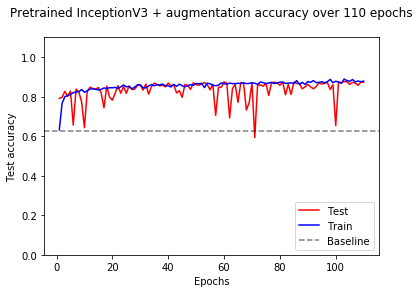

In [246]:
plot_accuracy('inc_res_aug.txt','Pretrained InceptionV3 + augmentation accuracy over 110 epochs\n')

             precision    recall  f1-score   support

          0       0.87      0.77      0.82       234
          1       0.87      0.93      0.90       390

avg / total       0.87      0.87      0.87       624



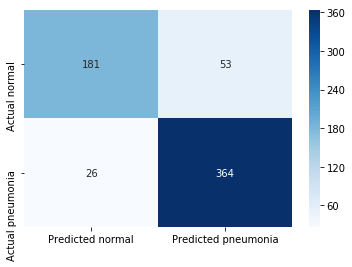

In [34]:
model_base = aug_model.predict(X_test_aug)
model_pred = [label_decoder(i) for i in model_base]
cm = confusion_matrix(test_labels, model_pred)
sns.heatmap(cm, annot=True,cmap='Blues',xticklabels = ['Predicted normal','Predicted pneumonia'],
           yticklabels=['Actual normal', 'Actual pneumonia'], fmt='d')
print(classification_report(test_labels, model_pred))

             precision    recall  f1-score   support

          0       0.83      0.62      0.71         8
          1       0.70      0.88      0.78         8

avg / total       0.77      0.75      0.75        16



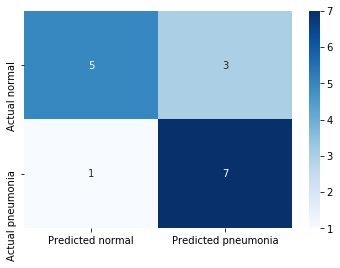

In [45]:
model_base = aug_model.predict(X_val_aug)
model_pred = [label_decoder(i) for i in model_base]
cm = confusion_matrix(val_labels, model_pred)
sns.heatmap(cm, annot=True,cmap='Blues',xticklabels = ['Predicted normal','Predicted pneumonia'],
           yticklabels=['Actual normal', 'Actual pneumonia'], fmt='d')
print(classification_report(val_labels, model_pred))

This model finally performs better than my first one, with an accuracy on the test images of 0.87. It doesn't perform quite as well on the validation set, with an accuracy of 0.77. One thing I have not taken into account thus far is the threshold I've set for assigning predicted labels, which is to assign 0 (normal) or 1 (pneumonia) based on which has the higher predicted probability (effectively a threshold of 0.5). It might make sense to adjust this threshold in a real-world situation.

As far as evaluating the model goes however, using a ROC-curve is a good way of determining the effectiveness of the classifier across a range of thresholds, so this is probably better way to finally evaluate the performance of the model.

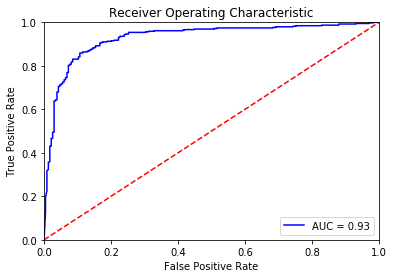

In [74]:
# calculate the fpr and tpr for all thresholds of the classification
probs = aug_model.predict_proba(X_test_aug)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(test_labels, preds)
roc_auc = auc(fpr, tpr)

import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

As can be seen here, the resulting AUC for this ROC-curve is 0.93, which is reasonably close to 1. Similar commercial software for the detection of tuberculosis is reported to have an AUC of 0.87-0.90, so an AUC of 0.93 is competitive with this standard. Further progress in this field has yielded AUCs of up to 0.99 though (2), so there remains room for improvement on this model.

In [76]:
#Saving weights and model
aug_model.save_weights('inc_imagenet_aug_110.h5')
model_json = aug_model.to_json()
with open('inc_imagenet_aug_110.json', "w") as json_file:
    json_file.write(model_json)
json_file.close()

------------------------------------------------------------------------------
## <a id='9'>9. Conclusions</a>

After testing multiple training conditions and architectures, the best test accuracy was obtained using InceptionV3 with pre-trained weights to perform feature extraction and then using a simple 4 layer classification model on images augmented with random translations, reflections and (non-random) rescaling. This model yielded an accuracy and f1-score of 0.87 and an AUC of 0.93 on the test image set. This model did not perform as well on the 16-image validation set, with an accuracy and f1 of 0.77 and 0.75 respectively. This difference is likely either due to overfitting to the test set or stochastic variation in the model.

In general, all models tested had a tendency to be highly accurate when identifying pneumonia images, but less accurate with normal images. This leads to a higher number of false positives over false negatives. This may have been an artefact of the classification method used, where a probability threshold of 0.5 was set when deciding if an image was pneumonia or not. Experimenting with fine-tuning this threshold is a recommended future step. Fortunately, evaluating the model with AUC-ROC bypasses this problem and it is recommended that this metric be used for future optimisations.

--------------------------------------------------------------
## <a id='10'>10. References</a>

1. Ruuskanen O, Lahti E, Jennings LC, Murdoch DR (2011). "Viral pneumonia". Lancet. 377 (9773).

2. Lakhani P and Sundaram B (2017). "Deep Learning at Chest Radiography: Automated Classification of Pulmonary Tuberculosis by Using Convolutional Neural Networks" Radiology. 284 (2). 
